## Notebook for Hard MoE implementation  
## 1. Set-up and Data Loading  
This is identical across all MoE implementations 

In [77]:
## Imports
import os
import sys
import time
from collections import defaultdict

import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
# setting device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cuda


In [3]:
# Define the transformation to convert to Tensor and flatten it
flatten_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.flatten()) # Flattens the C x H x W tensor to a 1D vector
])

DATA_DIR = "../data"

# Download and load the training dataset with the new transformation
train_dataset = datasets.MNIST(
    root = DATA_DIR,
    train = True,
    transform = flatten_transform,
    download = True
)

# Download and load the test dataset with the new transformation
test_dataset = datasets.MNIST(
    root = DATA_DIR,
    train = False,
    transform = flatten_transform,
    download = True
)

In [4]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
# Get the first image and its label from the training dataset
first_image, first_label = train_dataset[0]

# Print the shape of the image tensor
print(f"Shape of the first image: {first_image.shape}")
print(f"Label of the first image: {first_label}")

Number of training samples: 60000
Number of test samples: 10000
Shape of the first image: torch.Size([784])
Label of the first image: 5


In [195]:
## Set hyperparameters
BATCH_SIZE = 128

## Making data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset_size = test_dataset.data.shape[0]
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_dataset_size, shuffle=True)

## 2. HardMoE implementation

### 2.1 2017 Implementation  
The implementation below follows from the 2017 paper here https://arxiv.org/pdf/1701.06538

In [118]:
class OneLayerExpert(torch.nn.Module):
    """Simple expert with only one hidden layer"""
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # Hidden layer
        self.l_1 = torch.nn.Linear(input_size, hidden_size)
        self.relu_1 = torch.nn.ReLU()
        
        self.output = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.relu_1(self.l_1(x))
        x = self.output(x)
        return x

#the gating network. Here we only want the topk to contribute to the final output
#we will follow closely from this paper https://arxiv.org/pdf/1701.06538
#on how the gating network should be constructed for better load balancing
#this involves using sparsity and noise
class Gating(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, topk=2):
        super().__init__()
        #here we have a sparse layer trainable weight
        self.l_sparse = torch.nn.Linear(input_size, output_size)
        #here is a noise trainable weight
        self.l_noise = torch.nn.Linear(input_size, output_size)
        self.softplus_noise = torch.nn.Softplus()
        self.topk = topk

    def forward(self, x):
        #will be of shape batch size x num_experts
        sparsity = self.l_sparse(x)
        noise = self.softplus_noise(self.l_noise(x))
        # print("Noise shape:", noise.shape)
        # print("Sparsity shape:", sparsity.shape)
        # print("noise: ", noise)
        normal_noise  = torch.normal(mean=torch.zeros_like(noise), std=1).to(DEVICE)
        # print("normal noise shape:", normal_noise.shape)
        # print("normal noise: ", normal_noise)
        noise = normal_noise * noise
        # print("noisy shape:", noise.shape)
        # print("noisy: ", noise)
        x = sparsity + noise
        # print("x shape:", x.shape)  
        # print("x: ", x)
        '''This is the main difference between a soft MoE and HardMoE and this will cause problems with backpropagation
        since the gradient will be zero for all experts that are not in the topk'''
        if self.topk < x.shape[1]:
            # Get the top-k values
            topk_values, _ = torch.topk(x, self.topk, dim=1)
            # Get the k-th largest value for each sample
            threshold = topk_values[:, -1].unsqueeze(1) 
            # Set values below threshold to -inf
            x = torch.where(x >= threshold, x, torch.tensor(float('-inf')).to(x.device)) 
        # Apply softmax through expert/output dimension, so we get probability distribution but it will be over the topk experts
        x = F.softmax(x, dim=-1) 
        return x

class HardMOE(torch.nn.Module):
    def __init__(self, input_size, hidden_size_experts, hidden_size_gating, num_experts, output_size, topk, weight_importance=0.1):
        super().__init__()
        # Creating gating layer
        self.gate = Gating(
            input_size = input_size, 
            hidden_size = hidden_size_gating, 
            output_size = num_experts,
            topk = topk
        )
        # Create experts
        self.experts = nn.ModuleList(
            [OneLayerExpert(
                input_size=input_size, 
                hidden_size = hidden_size_experts, 
                output_size = output_size
            ) for _ in range(num_experts)]
        )
        self.weight_importance = weight_importance

    def forward(self, x):
        # if B = batch_size, N = expert_num, D_out = expert output dimension
        gating_output = self.gate(x) # shape: (B, N)
        #this follows the importance loss from the paper
        importance = gating_output.sum(0) # shape: (N,)
        # print("importance: ", importance)
        mean = torch.mean(importance)
        std_dev = torch.std(importance)
        cv = std_dev / mean
        loss_importance = self.weight_importance * cv * cv
        # print("Importance loss: ", loss_importance.item())
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=2) # shape: (B, D_out, N)
        # Calculating weighted sum:
        # 1. gating_output.unsqueeze -> (B, N, 1)
        # 2. torch.bmm(...) -> (B, D_out, 1)
        # 3. .squeeze(2) -> (B, D_out)
        output = torch.bmm(expert_outputs, gating_output.unsqueeze(2)).squeeze(2)
        
        return output, gating_output, loss_importance

### 2.2 2022 Implementation  
The below implementation follows from the 2022 paper here https://arxiv.org/pdf/2101.03961

In [ ]:
class OneLayerExpert_2022(torch.nn.Module):
    """Simple expert with only one hidden layer"""
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # Hidden layer
        self.l_1 = torch.nn.Linear(input_size, hidden_size)
        self.relu_1 = torch.nn.ReLU()
        
        self.output = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.relu_1(self.l_1(x))
        x = self.output(x)
        return x

#the gating network. Here we only want the topk to contribute to the final output
#we will follow closely from this paper https://arxiv.org/pdf/1701.06538
#on how the gating network should be constructed for better load balancing
#this involves using sparsity and noise
class Gating_2022(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, topk=2):
        super().__init__()
        #here we have a sparse layer trainable weight
        self.l_1 = torch.nn.Linear(input_size, hidden_size)
        #here is a noise trainable weight
        self.l_1_relu = torch.nn.ReLU()
        self.output = torch.nn.Linear(hidden_size, output_size)
        self.topk = topk

    def forward(self, x):
        #revert to a simple one layer network for gating
        x = self.l_1_relu(self.l_1(x))
        x = self.output(x)
        #introduce some noise during training to help with load balancing
        if self.training:
            noise = torch.randn_like(x) *0.01  # tunable std
            x = x + noise

        #we will do softmax with topk in the MoE layer since we will need it for load balancing
        return x

class HardMOE_2022(torch.nn.Module):
    def __init__(self, input_size, hidden_size_experts, hidden_size_gating, num_experts, output_size, topk, alpha=0.01):
        super().__init__()
        # Creating gating layer
        self.gate = Gating_2022(
            input_size = input_size, 
            hidden_size = hidden_size_gating, 
            output_size = num_experts,
            topk = topk
        )
        # Create experts
        self.experts = nn.ModuleList(
            [OneLayerExpert_2022(
                input_size = input_size, 
                hidden_size = hidden_size_experts, 
                output_size = output_size
            ) for _ in range(num_experts)]
        )
        self.alpha = alpha
        self.num_experts = num_experts
        self.topk = topk

    def forward(self, x):
        # if B = batch_size, N = expert_num, D_out = expert output dimension
        gating_output = self.gate(x) # shape: (B, N)
        # print("gating output: ", gating_output)
        # print("gating output shape: ", gating_output.shape)
        '''This is the main difference between a soft MoE and HardMoE and this will cause problems with backpropagation
        since the gradient will be zero for all experts that are not in the topk'''
        if self.topk < x.shape[1]:
            # Get the top-k values
            topk_values, _ = torch.topk(gating_output, self.topk, dim=1)
            # Get the k-th largest value for each sample
            threshold = topk_values[:, -1].unsqueeze(1) 
            # Set values below threshold to -inf
            temp = torch.where(gating_output >= threshold, gating_output, torch.tensor(float('-inf')).to(gating_output.device)) 
        # Apply softmax through expert/output dimension, so we get probability distribution but it will be over the topk experts
        expert_choice = F.softmax(temp, dim=-1) 
        #also want to do softmax on the gating output for the load balancing calculation
        gating_output = F.softmax(gating_output, dim=-1)
        # print("gating output: ", gating_output)
        # print("gating output shape: ", gating_output.shape)
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=2) # shape: (B, D_out, N)
        # Calculating weighted sum:
        # 1. gating_output.unsqueeze -> (B, N, 1)
        # 2. torch.bmm(...) -> (B, D_out, 1)
        # 3. .squeeze(2) -> (B, D_out)
        output = torch.bmm(expert_outputs, expert_choice.unsqueeze(2)).squeeze(2)
        #this is the fraction of probability assigned to each expert averaged over the batch
        importance = expert_choice.mean(dim=0)
        # print("importance: ", importance)
        #this is the number of tokens assigned to each expert averaged over the batch
        load = (expert_choice > 0).sum(dim=0) / expert_choice.shape[0]
        # print("load: ", load)
        bal_loss = (importance * load).sum() * self.num_experts * self.alpha
        #print("balancing loss: ", bal_loss.item())
        return output, expert_choice, bal_loss

In [262]:
network = HardMOE_2022(
    input_size = 28*28, 
    hidden_size_experts = 32, 
    hidden_size_gating = 16, 
    num_experts = 8, 
    output_size = 10,
    topk = 2
).to(DEVICE)
for _, (data, label) in enumerate(train_loader):
    data = data.to(DEVICE)
    label = label.to(DEVICE)
    output,_,_ = network(data)
    print(output)
    break

importance:  tensor([0.0000, 0.4547, 0.0000, 0.4508, 0.0036, 0.0000, 0.0909, 0.0000],
       device='cuda:0', grad_fn=<MeanBackward1>)
load:  tensor([0.0000, 0.9062, 0.0000, 0.8984, 0.0078, 0.0000, 0.1875, 0.0000],
       device='cuda:0')
128
tensor([[-0.0725,  0.0043,  0.1861,  ...,  0.0240, -0.0832,  0.0102],
        [-0.0610, -0.0837,  0.1511,  ...,  0.0530,  0.0411,  0.0129],
        [-0.0485, -0.0872,  0.2229,  ...,  0.0223,  0.0524,  0.0631],
        ...,
        [-0.1557,  0.0422,  0.2263,  ...,  0.0122, -0.0944,  0.0171],
        [-0.0421, -0.0108,  0.2335,  ...,  0.0467, -0.0521,  0.0325],
        [-0.0554, -0.0259,  0.2330,  ...,  0.0442, -0.1037,  0.0195]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


## 3. Training  
### 3.1 Set up

In [240]:
def calculate_accuracy(outputs, labels):
    _, output_index = torch.max(outputs, 1)
    return (output_index == labels).sum().item() / labels.size(0)

#training loop is largely unchanged, except we also store the gating outputs to calculate expert utilization
#and I will look at the gradients to see how training is done
def training_loop(train_loader, test_loader, num_epochs, model, loss_function, optimizer):
    model = model.to(DEVICE)
    # Metrics
    training_loss = []
    training_accuracy = []
    test_loss = []
    test_accuracy = []
    expert_utilization_history = []
    importance_loss_history = []
    
    print("Starting the Training Loop")
    for epoch in tqdm(range(num_epochs)):
        model.train()
        batch_loss = []
        batch_accuracy = []
        epoch_gating_outputs = [] 
        
        # Loop through batches (Training Phase)
        for _, (data, label) in enumerate(train_loader):
            data = data.to(DEVICE)
            label = label.to(DEVICE)
            
            # Forward pass
            outputs, gating_output, extra_loss = model(data)
            epoch_gating_outputs.append(gating_output.detach().cpu())
            #print("gating ouputs: ", gating_output)
            # Evaluate
            loss = loss_function(outputs, label) + extra_loss
            batch_loss.append(loss.item())
            batch_accuracy.append(calculate_accuracy(outputs.detach(), label.detach()))

            
            # Backward pass setting gradients to zero
            optimizer.zero_grad()
            loss.backward()
            #we can see that some experts will have zero gradients and will not learn anything
            # for name, param in model.named_parameters():
            #     if torch.all(param.grad == 0):
            #         print(f"{name} has 0 gradient and is of shape {param.shape}")
            #     else:
            #         print(f"{name} has gradient and is of shape {param.shape}: ", param.grad)
            optimizer.step()

        # Combine all gating outputs from the epoch into a single tensor
        all_gating_outputs = torch.cat(epoch_gating_outputs, dim=0) # list of (B, N) tensors -> (Total Samples, N)
        # print("All gating outputs shape:", all_gating_outputs.shape)
        print("All gating outputs sumed", all_gating_outputs.sum(dim = 0))
        # Calculate the average utilization for each expert over the entire training set
        avg_expert_utilization = all_gating_outputs.mean(dim=0).numpy() # (Total Samples, N) -> (N,)
                
        # Aggregate batch matrics
        training_accuracy.append(np.average(batch_accuracy))
        training_loss.append(np.average(batch_loss))
        expert_utilization_history.append(avg_expert_utilization)
        
        # Test Phase
        model.eval()
        test_loss_list = []
        test_accuracy_list = []
        
        with torch.no_grad():
            for _, (data, label) in enumerate(test_loader):
                data = data.to(DEVICE)
                label = label.to(DEVICE)
                
                # Forward pass
                test_predictions, _, importance_loss = model(data)
                
                # Evaluate
                loss = loss_function(test_predictions, label) 
                test_loss_list.append(loss.item())
                #add the importance loss so we can see how it changes over time
                importance_loss_history.append(importance_loss)
                # Use .detach() for metric calculation
                test_accuracy_list.append(calculate_accuracy(test_predictions.detach(), label.detach())) 

        # Aggregate batch matrics
        test_loss.append(np.average(test_loss_list))
        test_accuracy.append(np.average(test_accuracy_list))
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} done. Test loss {test_loss[-1]:.4f}. Test accuracy {test_accuracy[-1]:.4f}")
    
    return training_loss, training_accuracy, test_loss, test_accuracy, expert_utilization_history

### 3.3 MoE2017 training

In [ ]:
LEARNING_RATE = 0.0001
EPOCHS = 100

EXPERT_NUM = 8
MNIST_LINEAR_LENGTH = 784  # Input
MNIST_CLASS_NUM = 10       # Output
EXPERT_HIDDEN_SIZE = 25 
GATING_HIDDEN_SIZE = 10
TOP_K = 2

moe = HardMOE(
    input_size=MNIST_LINEAR_LENGTH,
    hidden_size_experts=EXPERT_HIDDEN_SIZE,
    hidden_size_gating=GATING_HIDDEN_SIZE,
    num_experts=EXPERT_NUM,
    output_size=MNIST_CLASS_NUM,
    topk=TOP_K
)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(moe.parameters(), lr=LEARNING_RATE)

In [125]:
training_start = time.time()

training_loss, training_accuracy, test_loss, test_accuracy, expert_utilization_history = \
    training_loop(
        train_loader=train_loader, 
        test_loader=test_loader, 
        num_epochs=EPOCHS, 
        model=moe, 
        loss_function=loss, 
        optimizer=optimizer)

training_end = time.time()
training_duration = training_end-training_start

Starting the Training Loop


  0%|          | 0/100 [00:00<?, ?it/s]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.2636, 0.0000, 0.0000, 0.0000, 0.0000, 0.7364, 0.0000, 0.0000])


  1%|          | 1/100 [00:08<13:14,  8.02s/it]

Epoch: 0 done. Test loss 2.3059. Test accuracy 0.1035
All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.4655, 0.0000, 0.0000, 0.0000, 0.0000, 0.5345, 0.0000])


  2%|▏         | 2/100 [00:16<13:13,  8.09s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.3382, 0.0000, 0.6618, 0.0000, 0.0000])


  3%|▎         | 3/100 [00:24<12:58,  8.02s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5203, 0.4797, 0.0000])


  4%|▍         | 4/100 [00:32<12:47,  7.99s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4384, 0.5616, 0.0000])


  5%|▌         | 5/100 [00:39<12:37,  7.97s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.4869, 0.5131, 0.0000, 0.0000, 0.0000])


  6%|▌         | 6/100 [00:47<12:27,  7.95s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.4340, 0.0000, 0.0000, 0.5660, 0.0000, 0.0000, 0.0000, 0.0000])


  7%|▋         | 7/100 [00:56<12:25,  8.01s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.5456, 0.0000, 0.0000, 0.0000, 0.4544, 0.0000])


  8%|▊         | 8/100 [01:03<12:11,  7.95s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.5658, 0.0000, 0.0000, 0.0000, 0.4342, 0.0000, 0.0000])


  9%|▉         | 9/100 [01:11<12:02,  7.94s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.3506, 0.0000, 0.0000, 0.0000, 0.6494])


 10%|█         | 10/100 [01:19<11:58,  7.98s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.5105, 0.4895, 0.0000, 0.0000])


 11%|█         | 11/100 [01:32<14:01,  9.46s/it]

Epoch: 10 done. Test loss 2.2927. Test accuracy 0.1222
All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.5540, 0.0000, 0.4460, 0.0000])


 12%|█▏        | 12/100 [01:42<13:55,  9.50s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.3678, 0.6322, 0.0000, 0.0000, 0.0000, 0.0000])


 13%|█▎        | 13/100 [01:50<13:23,  9.23s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.2721, 0.7279, 0.0000, 0.0000])


 14%|█▍        | 14/100 [02:00<13:19,  9.30s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.4341, 0.0000, 0.0000, 0.0000, 0.0000, 0.5659, 0.0000])


 15%|█▌        | 15/100 [02:08<12:52,  9.09s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.2782, 0.0000, 0.0000, 0.7218, 0.0000])


 16%|█▌        | 16/100 [02:17<12:27,  8.90s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.7020, 0.0000, 0.0000, 0.2980, 0.0000, 0.0000, 0.0000])


 17%|█▋        | 17/100 [02:25<12:09,  8.79s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.6460, 0.3540, 0.0000, 0.0000])


 18%|█▊        | 18/100 [02:34<11:47,  8.63s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.5331, 0.4669, 0.0000, 0.0000])


 19%|█▉        | 19/100 [02:42<11:27,  8.49s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4968, 0.5032, 0.0000])


 20%|██        | 20/100 [02:50<11:12,  8.40s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.6085, 0.0000, 0.0000, 0.0000, 0.3915, 0.0000])


 21%|██        | 21/100 [02:58<11:01,  8.37s/it]

Epoch: 20 done. Test loss 2.2799. Test accuracy 0.1599
All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.2897, 0.0000, 0.0000, 0.0000, 0.0000, 0.7103, 0.0000])


 22%|██▏       | 22/100 [03:07<10:49,  8.32s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.2619, 0.7381, 0.0000, 0.0000])


 23%|██▎       | 23/100 [03:15<10:42,  8.35s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.4231, 0.5769, 0.0000, 0.0000, 0.0000, 0.0000])


 24%|██▍       | 24/100 [03:23<10:31,  8.31s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.2824, 0.7176, 0.0000, 0.0000])


 25%|██▌       | 25/100 [03:32<10:27,  8.37s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5924, 0.4076])


 26%|██▌       | 26/100 [03:40<10:15,  8.32s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.3326, 0.6674, 0.0000, 0.0000, 0.0000, 0.0000])


 27%|██▋       | 27/100 [03:48<10:06,  8.31s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.4169, 0.5831, 0.0000, 0.0000, 0.0000])


 28%|██▊       | 28/100 [03:56<09:56,  8.29s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.4563, 0.0000, 0.5437, 0.0000, 0.0000, 0.0000, 0.0000])


 29%|██▉       | 29/100 [04:05<09:47,  8.27s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.5425, 0.0000, 0.4575, 0.0000])


 30%|███       | 30/100 [04:13<09:40,  8.29s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.5534, 0.0000, 0.0000, 0.4466, 0.0000, 0.0000, 0.0000, 0.0000])


 31%|███       | 31/100 [04:21<09:29,  8.25s/it]

Epoch: 30 done. Test loss 2.2680. Test accuracy 0.1755
All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.4497, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5503])


 32%|███▏      | 32/100 [04:29<09:21,  8.26s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.4434, 0.0000, 0.5566, 0.0000, 0.0000, 0.0000, 0.0000])


 33%|███▎      | 33/100 [04:38<09:12,  8.25s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.4913, 0.5087, 0.0000, 0.0000])


 34%|███▍      | 34/100 [04:46<09:09,  8.33s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.5932, 0.0000, 0.4068, 0.0000, 0.0000])


 35%|███▌      | 35/100 [04:54<08:58,  8.28s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.5448, 0.0000, 0.4552, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


 36%|███▌      | 36/100 [05:02<08:47,  8.24s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.5139, 0.0000, 0.0000, 0.4861, 0.0000, 0.0000])


 37%|███▋      | 37/100 [05:11<08:40,  8.26s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.5115, 0.0000, 0.0000, 0.0000, 0.0000, 0.4885, 0.0000])


 38%|███▊      | 38/100 [05:19<08:32,  8.26s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.4274, 0.0000, 0.0000, 0.5726])


 39%|███▉      | 39/100 [05:27<08:22,  8.24s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.5089, 0.0000, 0.4911, 0.0000, 0.0000, 0.0000, 0.0000])


 40%|████      | 40/100 [05:37<08:33,  8.57s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3898, 0.0000, 0.6102])


 41%|████      | 41/100 [05:45<08:28,  8.62s/it]

Epoch: 40 done. Test loss 2.2503. Test accuracy 0.2041
All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.5874, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4126])


 42%|████▏     | 42/100 [05:54<08:22,  8.67s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.5137, 0.0000, 0.0000, 0.0000, 0.0000, 0.4863, 0.0000, 0.0000])


 43%|████▎     | 43/100 [06:03<08:12,  8.64s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.5632, 0.0000, 0.0000, 0.0000, 0.0000, 0.4368, 0.0000, 0.0000])


 44%|████▍     | 44/100 [06:11<08:00,  8.58s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.5708, 0.0000, 0.4292, 0.0000, 0.0000, 0.0000])


 45%|████▌     | 45/100 [06:19<07:48,  8.52s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.5327, 0.0000, 0.4673, 0.0000, 0.0000])


 46%|████▌     | 46/100 [06:28<07:39,  8.50s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.4846, 0.0000, 0.0000, 0.0000, 0.0000, 0.5154, 0.0000, 0.0000])


 47%|████▋     | 47/100 [06:37<07:32,  8.53s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.4851, 0.5149, 0.0000, 0.0000, 0.0000])


 48%|████▊     | 48/100 [06:45<07:23,  8.52s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.6276, 0.3724, 0.0000, 0.0000])


 49%|████▉     | 49/100 [06:53<07:12,  8.48s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.6113, 0.0000, 0.0000, 0.3887, 0.0000])


 50%|█████     | 50/100 [07:02<07:04,  8.49s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.3973, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6027, 0.0000])


 51%|█████     | 51/100 [07:10<06:55,  8.48s/it]

Epoch: 50 done. Test loss 2.2306. Test accuracy 0.2257
All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.5387, 0.0000, 0.0000, 0.0000, 0.0000, 0.4613, 0.0000])


 52%|█████▏    | 52/100 [07:19<06:43,  8.42s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.3109, 0.0000, 0.6891, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


 53%|█████▎    | 53/100 [07:27<06:32,  8.36s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.4424, 0.0000, 0.0000, 0.5576, 0.0000, 0.0000, 0.0000])


 54%|█████▍    | 54/100 [07:35<06:25,  8.39s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.4461, 0.5539, 0.0000, 0.0000])


 55%|█████▌    | 55/100 [07:44<06:15,  8.34s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.4082, 0.0000, 0.0000, 0.5918, 0.0000])


 56%|█████▌    | 56/100 [07:52<06:04,  8.28s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.5867, 0.4133, 0.0000, 0.0000, 0.0000, 0.0000])


 57%|█████▋    | 57/100 [08:00<05:56,  8.28s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3811, 0.6189])


 58%|█████▊    | 58/100 [08:08<05:46,  8.25s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.5983, 0.0000, 0.0000, 0.4017, 0.0000, 0.0000, 0.0000])


 59%|█████▉    | 59/100 [08:16<05:37,  8.23s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.5995, 0.0000, 0.0000, 0.4005, 0.0000, 0.0000])


 60%|██████    | 60/100 [08:25<05:30,  8.27s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.6061, 0.0000, 0.0000, 0.0000, 0.3939, 0.0000, 0.0000, 0.0000])


 61%|██████    | 61/100 [08:33<05:23,  8.30s/it]

Epoch: 60 done. Test loss 2.2057. Test accuracy 0.2395
All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.4823, 0.0000, 0.0000, 0.5177])


 62%|██████▏   | 62/100 [08:41<05:14,  8.28s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.3849, 0.0000, 0.0000, 0.0000, 0.0000, 0.6151])


 63%|██████▎   | 63/100 [08:50<05:07,  8.32s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.2954, 0.0000, 0.0000, 0.7046, 0.0000, 0.0000, 0.0000, 0.0000])


 64%|██████▍   | 64/100 [08:58<04:59,  8.31s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.9155, 0.0845, 0.0000, 0.0000, 0.0000])


 65%|██████▌   | 65/100 [09:06<04:50,  8.30s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.2775, 0.0000, 0.0000, 0.7225, 0.0000, 0.0000, 0.0000, 0.0000])


 66%|██████▌   | 66/100 [09:15<04:42,  8.30s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.3657, 0.6343, 0.0000, 0.0000])


 67%|██████▋   | 67/100 [09:23<04:32,  8.27s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.1694, 0.8306, 0.0000, 0.0000, 0.0000])


 68%|██████▊   | 68/100 [09:32<04:31,  8.49s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.5353, 0.0000, 0.0000, 0.0000, 0.4647])


 69%|██████▉   | 69/100 [09:41<04:30,  8.71s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.7903, 0.0000, 0.0000, 0.0000, 0.2097])


 70%|███████   | 70/100 [09:50<04:19,  8.66s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3465, 0.6535, 0.0000])


 71%|███████   | 71/100 [09:58<04:11,  8.66s/it]

Epoch: 70 done. Test loss 2.1719. Test accuracy 0.2580
All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.1903, 0.0000, 0.0000, 0.8097, 0.0000, 0.0000, 0.0000, 0.0000])


 72%|███████▏  | 72/100 [10:07<04:01,  8.64s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.6885, 0.0000, 0.3115, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


 73%|███████▎  | 73/100 [10:15<03:50,  8.52s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.5615, 0.0000, 0.0000, 0.0000, 0.4385, 0.0000, 0.0000])


 74%|███████▍  | 74/100 [10:25<03:53,  8.99s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4723, 0.5277])


 75%|███████▌  | 75/100 [10:35<03:50,  9.22s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5609, 0.4391])


 76%|███████▌  | 76/100 [10:43<03:35,  8.98s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.4096, 0.0000, 0.0000, 0.0000, 0.5904])


 77%|███████▋  | 77/100 [10:52<03:25,  8.93s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.4634, 0.5366, 0.0000, 0.0000])


 78%|███████▊  | 78/100 [11:01<03:14,  8.85s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.5713, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4287])


 79%|███████▉  | 79/100 [11:09<03:02,  8.70s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.3536, 0.0000, 0.0000, 0.0000, 0.0000, 0.6464])


 80%|████████  | 80/100 [11:17<02:50,  8.54s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.3654, 0.0000, 0.0000, 0.0000, 0.0000, 0.6346])


 81%|████████  | 81/100 [11:25<02:40,  8.43s/it]

Epoch: 80 done. Test loss 2.1332. Test accuracy 0.2739
All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.7834, 0.0000, 0.0000, 0.0000, 0.2166])


 82%|████████▏ | 82/100 [11:34<02:30,  8.35s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.4005, 0.0000, 0.5995, 0.0000, 0.0000])


 83%|████████▎ | 83/100 [11:42<02:20,  8.24s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.6143, 0.0000, 0.0000, 0.0000, 0.3857, 0.0000])


 84%|████████▍ | 84/100 [11:50<02:11,  8.20s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.5038, 0.0000, 0.4962, 0.0000, 0.0000, 0.0000])


 85%|████████▌ | 85/100 [11:58<02:01,  8.13s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6449, 0.3551, 0.0000])


 86%|████████▌ | 86/100 [12:06<01:54,  8.17s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.6014, 0.0000, 0.3986, 0.0000])


 87%|████████▋ | 87/100 [12:14<01:46,  8.19s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4809, 0.5191])


 88%|████████▊ | 88/100 [12:22<01:37,  8.14s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.4455, 0.0000, 0.0000, 0.0000, 0.5545])


 89%|████████▉ | 89/100 [12:30<01:28,  8.09s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.5624, 0.4376, 0.0000, 0.0000, 0.0000])


 90%|█████████ | 90/100 [12:38<01:20,  8.04s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5419, 0.4581, 0.0000])


 91%|█████████ | 91/100 [12:46<01:12,  8.01s/it]

Epoch: 90 done. Test loss 2.0999. Test accuracy 0.2927
All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.6850, 0.0000, 0.0000, 0.3150, 0.0000])


 92%|█████████▏| 92/100 [12:56<01:07,  8.49s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.7116, 0.0000, 0.0000, 0.2884, 0.0000])


 93%|█████████▎| 93/100 [13:07<01:04,  9.24s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.4980, 0.0000, 0.0000, 0.0000, 0.5020])


 94%|█████████▍| 94/100 [13:19<01:01, 10.22s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.6062, 0.0000, 0.3938, 0.0000, 0.0000])


 95%|█████████▌| 95/100 [13:32<00:54, 10.89s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.7076, 0.2924, 0.0000, 0.0000, 0.0000])


 96%|█████████▌| 96/100 [13:43<00:44, 11.15s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.4976, 0.0000, 0.5024, 0.0000, 0.0000])


 97%|█████████▋| 97/100 [13:56<00:35, 11.67s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.3009, 0.0000, 0.0000, 0.0000, 0.6991, 0.0000, 0.0000])


 98%|█████████▊| 98/100 [14:07<00:22, 11.44s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.4165, 0.0000, 0.0000, 0.0000, 0.5835])


 99%|█████████▉| 99/100 [14:17<00:10, 10.98s/it]

All gating outputs shape: torch.Size([60000, 8])
All gating outputs on first iteration: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3761, 0.6239])


100%|██████████| 100/100 [14:27<00:00,  8.67s/it]


In [13]:
# Training test plot curve code that was provided in assignment 1 to get the plots
def training_curve_plot(title, train_costs, test_costs, train_accuracy, test_accuracy, batch_size, learning_rate, training_time, epochs):
    """Plots the train-test cost and accuracy curve"""
    lg=18
    md=13
    sm=9
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title, y=1.15, fontsize=lg)
    
    ## Add subtitle with hyperparameters and training time
    sub = f'| Batch size:{batch_size} | Learning rate:{learning_rate} | Number of Epochs:{epochs} | Training Time:{round(training_time)}sec |'
    fig.text(0.5, 0.99, sub, ha='center', fontsize=md)
    
    x = range(1, len(train_costs)+1)
    
    ## Cost/Loss subplot
    axs[0].plot(x, train_costs, label=f'Final train cost: {train_costs[-1]:.4f}')
    axs[0].plot(x, test_costs, label=f'Final test cost: {test_costs[-1]:.4f}')
    axs[0].set_title('Costs', fontsize=md)
    axs[0].set_xlabel('Epochs', fontsize=md)
    axs[0].set_ylabel('Cost', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    #axs[0].set_yscale('log') # Optionally use a logarithmic y-scale
    
    ## Accuracy subplot
    axs[1].plot(x, train_accuracy, label=f'Final train accuracy: {100*train_accuracy[-1]:.2f}%')
    axs[1].plot(x, test_accuracy, label=f'Final test accuracy: {100*test_accuracy[-1]:.2f}%')
    axs[1].set_title('Accuracy', fontsize=md)
    axs[1].set_xlabel('Epochs', fontsize=md)
    axs[1].set_ylabel('Accuracy (%)', fontsize=sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)
    
    
def plot_utilization_histogram(
    epochs_to_plot: list[int],
    utilization_data: dict[int, np.ndarray],
    expert_names: list[str] = None,
    figsize: tuple[int, int] = (12, 4)
):
    """Creates a series of bar plots showing expert utilization for specified epochs."""
    num_epochs = len(epochs_to_plot)

    if num_epochs == 0:
        print("No epochs to plot.")
        return

    # Use a single row layout for simplicity
    fig, axes = plt.subplots(
        nrows=1,
        ncols=num_epochs,
        figsize=(figsize[0], figsize[1]),
        sharey=True # Share the y-axis (0-1 range)
    )

    # If there is only one subplot, axes is not an array, so make it one
    if num_epochs == 1:
        axes = [axes]

    # Determine expert names if not provided
    first_epoch_data = utilization_data[epochs_to_plot[0]]
    num_experts = len(first_epoch_data)
    if expert_names is None:
        expert_names = [f'Expert {i}' for i in range(num_experts)]

    x = np.arange(num_experts) # the label locations
    width = 0.8 # the width of the bars

    for ax, epoch in zip(axes, epochs_to_plot):
        utilization = utilization_data.get(epoch)

        if utilization is None:
            print(f"Warning: No data found for epoch {epoch}. Skipping.")
            continue

        # Create the bar plot
        ax.bar(x, utilization, width, color='skyblue', edgecolor='black')

        # Set title and labels
        ax.set_title(f'Epoch {epoch}', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(expert_names, rotation=45, ha='right')
        ax.set_ylim(0, 1.0) # Set the y-limit from 0 to 1 as requested
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)

        # Only set y-label on the first subplot
        if ax == axes[0]:
            ax.set_ylabel('Average Utilization (0 to 1)', fontsize=10)

        # Add utilization values on top of the bars
        for i, val in enumerate(utilization):
            ax.text(x[i], val + 0.02, f'{val:.2f}', ha='center', va='bottom', fontsize=8)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.suptitle('Expert Utilization Across Epochs', y=1.02, fontsize=14, fontweight='bold')
    #plt.savefig('expert_utilization_plot.png')
    plt.close(fig)


def plot_utilization_trends(
    epochs_to_plot: list[int],
    utilization_data: dict[int, np.ndarray],
    expert_names: list[str] = None,
    figsize: tuple[int, int] = (10, 6)
):
    """Creates a line/scatterplot showing the utilization trend of each expert across the specified epochs."""
    if not epochs_to_plot:
        print("No epochs to plot.")
        return

    # Filter and sort epochs for which we have data
    valid_epochs = sorted([e for e in epochs_to_plot if e in utilization_data])

    if not valid_epochs:
        print("No valid utilization data found for the specified epochs.")
        return

    # Collect all utilization arrays in valid epoch order
    all_utilizations = [utilization_data[e] for e in valid_epochs]

    # Stack them vertically (rows are epochs, columns are experts)
    utilization_matrix = np.vstack(all_utilizations)

    # Transpose to get (rows are experts, columns are epochs)
    expert_utilization_trends = utilization_matrix.T

    num_experts = expert_utilization_trends.shape[0]

    # Determine expert names if not provided
    if expert_names is None:
        expert_names = [f'Expert {i}' for i in range(num_experts)]
    elif len(expert_names) != num_experts:
        print(f"Warning: Expert names list length ({len(expert_names)}) does not match number of experts ({num_experts}). Using default names.")
        expert_names = [f'Expert {i}' for i in range(num_experts)]

    fig, ax = plt.subplots(figsize=figsize)

    for i in range(num_experts):
        expert_data = expert_utilization_trends[i]
        expert_name = expert_names[i]

        # Plot line and scatter points
        ax.plot(valid_epochs, expert_data, label=expert_name, marker='o', linestyle='-')

    ax.set_title('Expert Utilization Trends Across Epochs', fontsize=14, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Average Utilization (0 to 1)', fontsize=12)

    # Set x-ticks to be only the plotted epoch numbers
    ax.set_xticks(valid_epochs)

    # Ensure y-axis is from 0 to 1
    ax.set_ylim(0, 1.0)

    # Add legend
    ax.legend(title="Experts", loc='best', fontsize=10)

    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    #plt.savefig('expert_utilization_trends.png')
    plt.close(fig)
    
    import numpy as np
import matplotlib.pyplot as plt

def plot_utilization_histogram(
    epochs_to_plot: list[int],
    utilization_data: list[np.ndarray],
    expert_names: list[str] = None,
    figsize: tuple[int, int] = (12, 4)
):
    """Creates a series of bar plots showing expert utilization for specified epochs."""
    num_epochs = len(epochs_to_plot)
    # Get used data from overall utilization history
    utilization_data = [utilization_data[i] for i in epochs_to_plot]

    if num_epochs == 0:
        print("No epochs to plot.")
        return

    # Check for data consistency
    if len(utilization_data) != num_epochs:
        print(f"Error: Number of epochs to plot ({num_epochs}) does not match number of utilization data arrays ({len(utilization_data)}).")
        return

    # Use a single row layout for simplicity
    fig, axes = plt.subplots(
        nrows=1,
        ncols=num_epochs,
        figsize=(figsize[0], figsize[1]),
        sharey=True # Share the y-axis (0-1 range)
    )

    # If there is only one subplot, axes is not an array, so make it one
    if num_epochs == 1:
        axes = np.array([axes]) # Use np.array for consistent iteration

    # Determine expert names if not provided
    first_epoch_data = utilization_data[0]
    num_experts = len(first_epoch_data)
    if expert_names is None:
        expert_names = [f'Expert {i}' for i in range(num_experts)]

    x = np.arange(num_experts) # the label locations
    width = 0.8 # the width of the bars

    for ax, epoch, utilization in zip(axes, epochs_to_plot, utilization_data):
        # The utilization data is now directly available, no dict.get() needed
        if utilization is None: # Should not happen if data is well-formed, but good check
            print(f"Warning: Data for epoch {epoch} is None. Skipping.")
            continue

        # Create the bar plot
        ax.bar(x, utilization, width, color='skyblue', edgecolor='black')

        # Set title and labels
        ax.set_title(f'Epoch {epoch}', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(expert_names, rotation=45, ha='right')
        ax.set_ylim(0, 1.0) # Set the y-limit from 0 to 1 as requested
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)

        # Only set y-label on the first subplot (axes[0] is the first one)
        if ax == axes[0]:
            ax.set_ylabel('Average Utilization (0 to 1)', fontsize=10)

        # Add utilization values on top of the bars
        for i, val in enumerate(utilization):
            ax.text(x[i], val + 0.02, f'{val:.2f}', ha='center', va='bottom', fontsize=8)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.suptitle('Expert Utilization Across Epochs', y=1.02, fontsize=14, fontweight='bold')
    plt.show()


def plot_utilization_trends(
    utilization_data: list[np.ndarray],
    expert_names: list[str] = None,
    figsize: tuple[int, int] = (10, 6)
):
    """Creates a line/scatterplot showing the utilization trend of each expert across the epochs."""
    
    num_epochs = len(utilization_data)

    # Stack them vertically (rows are epochs, columns are experts)
    # The epochs in valid_epochs now correspond to the rows in the matrix
    utilization_matrix = np.vstack(utilization_data)

    # Transpose to get (rows are experts, columns are epochs)
    expert_utilization_trends = utilization_matrix.T

    num_experts = expert_utilization_trends.shape[0]
    
    # Determine expert names if not provided
    if expert_names is None:
        expert_names = [f'Expert {i}' for i in range(num_experts)]
    elif len(expert_names) != num_experts:
        print(f"Warning: Expert names list length ({len(expert_names)}) does not match number of experts ({num_experts}). Using default names.")
        expert_names = [f'Expert {i}' for i in range(num_experts)]

    fig, ax = plt.subplots(figsize=figsize)

    for i in range(num_experts):
        expert_data = expert_utilization_trends[i]
        expert_name = expert_names[i]

        # Plot line and scatter points
        ax.plot(range(num_epochs), expert_data, label=expert_name, marker='o', linestyle='-')

    ax.set_title('Expert Utilization Trends Across Epochs', fontsize=14, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Average Utilization (0 to 1)', fontsize=12)

    # Set x-ticks to be only the plotted epoch numbers
    ax.set_xticks(range(0, num_epochs, 20))

    # Ensure y-axis is from 0 to 1
    ax.set_ylim(0, 1.0)

    # Add legend
    ax.legend(title="Experts", loc='best', fontsize=10)

    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

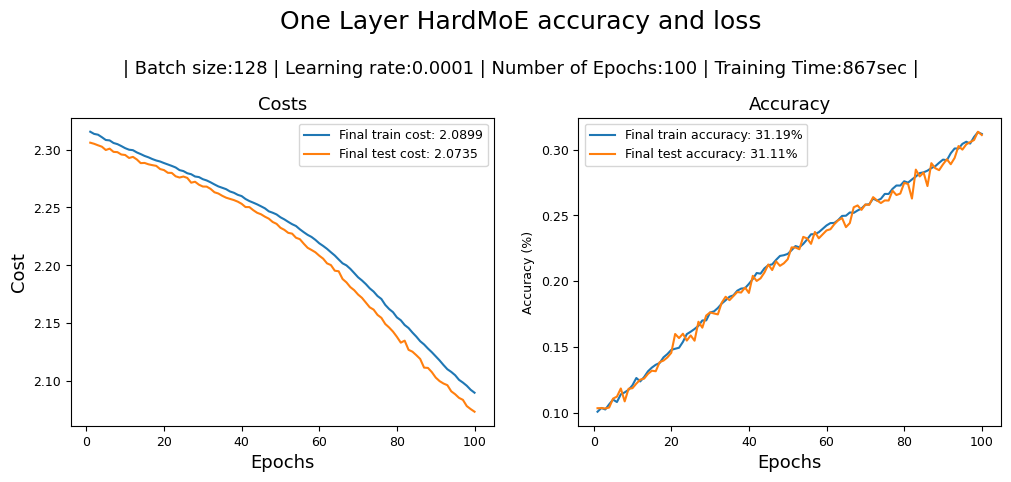

In [126]:
training_curve_plot(
    title="One Layer HardMoE accuracy and loss", 
    train_costs=training_loss, 
    test_costs=test_loss, 
    train_accuracy=training_accuracy, 
    test_accuracy=test_accuracy, 
    batch_size=BATCH_SIZE, 
    learning_rate=LEARNING_RATE, 
    training_time=training_duration, 
    epochs=EPOCHS)

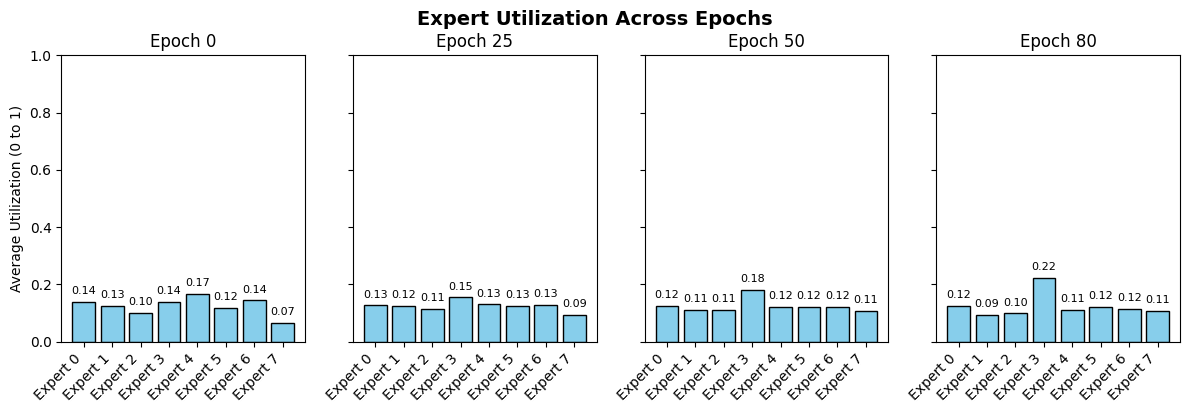

In [130]:
plot_utilization_histogram(
    epochs_to_plot=[0, 25, 50, 80], 
    utilization_data=expert_utilization_history
)

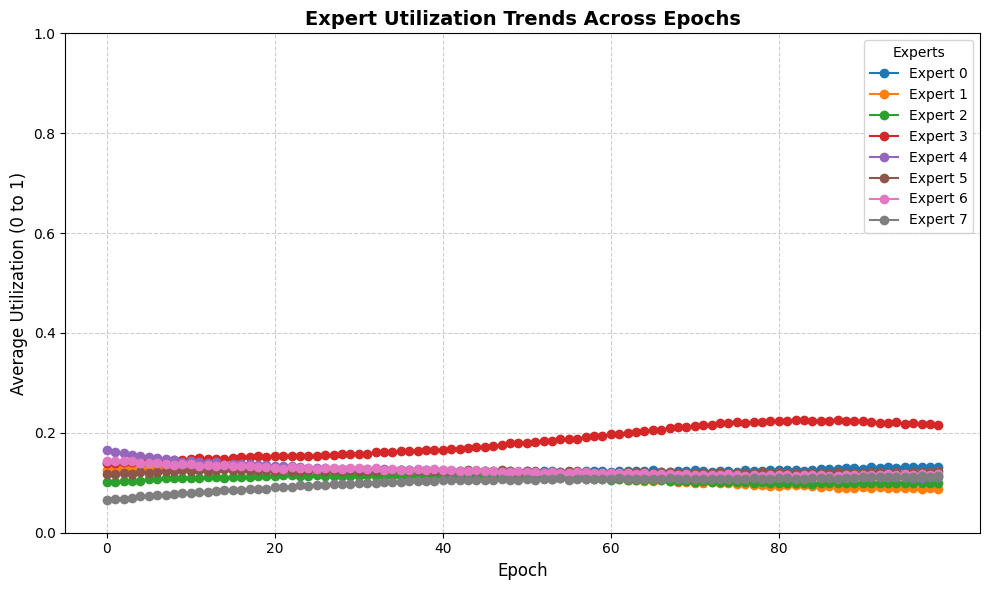

In [128]:
plot_utilization_trends(utilization_data=expert_utilization_history)

### 3.4 MoE 2022 Training

In [247]:
LEARNING_RATE = 0.001
EPOCHS = 200

EXPERT_NUM = 8
MNIST_LINEAR_LENGTH = 784  # Input
MNIST_CLASS_NUM = 10       # Output
EXPERT_HIDDEN_SIZE = 64 
GATING_HIDDEN_SIZE = 32
TOP_K = 2
ALPHA = 0.1

moe_2022 = HardMOE_2022(
    input_size=MNIST_LINEAR_LENGTH,
    hidden_size_experts=EXPERT_HIDDEN_SIZE,
    hidden_size_gating=GATING_HIDDEN_SIZE,
    num_experts=EXPERT_NUM,
    output_size=MNIST_CLASS_NUM,
    topk=TOP_K,
    alpha=ALPHA
)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(moe.parameters(), lr=LEARNING_RATE)

In [248]:
training_start = time.time()

training_loss, training_accuracy, test_loss, test_accuracy, expert_utilization_history = \
    training_loop(
        train_loader=train_loader, 
        test_loader=test_loader, 
        num_epochs=EPOCHS, 
        model=moe_2022, 
        loss_function=loss, 
        optimizer=optimizer)

training_end = time.time()
training_duration = training_end-training_start

Starting the Training Loop


  0%|          | 0/200 [00:00<?, ?it/s]

All gating outputs sumed tensor([ 6375.4307,    24.0183,   219.2658, 20025.4551,   915.9129,   358.5177,
        18877.2188, 13204.1797])


  0%|          | 1/200 [00:08<27:29,  8.29s/it]

Epoch: 0 done. Test loss 2.3142. Test accuracy 0.0923
All gating outputs sumed tensor([ 6322.7080,    20.0040,   231.5991, 19997.6777,   920.1216,   361.6747,
        18881.1758, 13265.0391])


  1%|          | 2/200 [00:16<28:08,  8.53s/it]

All gating outputs sumed tensor([ 6444.4756,    22.0322,   238.4635, 19880.5898,   911.5317,   350.7295,
        18822.8242, 13329.3525])


  2%|▏         | 3/200 [00:26<29:19,  8.93s/it]

All gating outputs sumed tensor([6.3932e+03, 1.7875e+01, 2.1998e+02, 2.0009e+04, 9.1377e+02, 3.5391e+02,
        1.8853e+04, 1.3239e+04])


  2%|▏         | 4/200 [00:35<28:53,  8.85s/it]

All gating outputs sumed tensor([6.3116e+03, 1.7077e+01, 2.1339e+02, 1.9966e+04, 9.3139e+02, 3.5614e+02,
        1.8836e+04, 1.3369e+04])


  2%|▎         | 5/200 [00:45<30:18,  9.33s/it]

All gating outputs sumed tensor([6.5061e+03, 1.9484e+01, 2.3655e+02, 1.9860e+04, 9.2705e+02, 3.7477e+02,
        1.8829e+04, 1.3247e+04])


  3%|▎         | 6/200 [00:53<29:00,  8.97s/it]

All gating outputs sumed tensor([6.5150e+03, 1.7985e+01, 2.2524e+02, 1.9965e+04, 8.9709e+02, 3.6236e+02,
        1.8784e+04, 1.3233e+04])


  4%|▎         | 7/200 [01:01<28:03,  8.73s/it]

All gating outputs sumed tensor([6.3452e+03, 1.7196e+01, 2.4153e+02, 1.9963e+04, 9.1847e+02, 3.4626e+02,
        1.8870e+04, 1.3298e+04])


  4%|▍         | 8/200 [01:09<27:19,  8.54s/it]

All gating outputs sumed tensor([6.4008e+03, 1.9837e+01, 2.4878e+02, 1.9978e+04, 8.9613e+02, 3.4652e+02,
        1.8871e+04, 1.3239e+04])


  4%|▍         | 9/200 [01:18<26:52,  8.44s/it]

All gating outputs sumed tensor([ 6396.6455,    24.5975,   223.6537, 20005.4688,   920.3972,   365.9037,
        18810.3066, 13253.0273])


  5%|▌         | 10/200 [01:26<26:31,  8.38s/it]

All gating outputs sumed tensor([6.4411e+03, 1.9699e+01, 2.4968e+02, 1.9985e+04, 8.7350e+02, 3.5128e+02,
        1.8887e+04, 1.3193e+04])


  6%|▌         | 11/200 [01:34<26:21,  8.37s/it]

Epoch: 10 done. Test loss 2.3142. Test accuracy 0.0923
All gating outputs sumed tensor([6.4633e+03, 1.8248e+01, 2.2987e+02, 1.9963e+04, 9.2956e+02, 3.2906e+02,
        1.8871e+04, 1.3196e+04])


  6%|▌         | 12/200 [01:42<26:06,  8.33s/it]

All gating outputs sumed tensor([ 6363.3501,    20.5804,   238.0110, 19980.7773,   935.7953,   350.4869,
        18834.7598, 13276.2402])


  6%|▋         | 13/200 [01:51<26:08,  8.39s/it]

All gating outputs sumed tensor([6.4027e+03, 1.5749e+01, 2.2644e+02, 2.0025e+04, 8.7975e+02, 3.7982e+02,
        1.8772e+04, 1.3298e+04])


  7%|▋         | 14/200 [02:00<26:13,  8.46s/it]

All gating outputs sumed tensor([6.4070e+03, 1.4343e+01, 2.3896e+02, 2.0020e+04, 9.2718e+02, 3.6794e+02,
        1.8811e+04, 1.3214e+04])


  8%|▊         | 15/200 [02:08<26:08,  8.48s/it]

All gating outputs sumed tensor([6.3674e+03, 1.6997e+01, 2.0525e+02, 2.0032e+04, 9.4991e+02, 3.8446e+02,
        1.8761e+04, 1.3283e+04])


  8%|▊         | 16/200 [02:17<25:56,  8.46s/it]

All gating outputs sumed tensor([6.4276e+03, 1.7932e+01, 2.4553e+02, 1.9893e+04, 9.1166e+02, 3.5292e+02,
        1.8768e+04, 1.3384e+04])


  8%|▊         | 17/200 [02:25<25:43,  8.44s/it]

All gating outputs sumed tensor([ 6429.6001,    21.3807,   251.4040, 19978.8574,   906.3158,   355.2146,
        18799.9082, 13257.3184])


  9%|▉         | 18/200 [02:33<25:18,  8.34s/it]

All gating outputs sumed tensor([6.3413e+03, 1.6390e+01, 2.3263e+02, 1.9980e+04, 9.0966e+02, 3.5011e+02,
        1.8752e+04, 1.3417e+04])


 10%|▉         | 19/200 [02:41<25:04,  8.31s/it]

All gating outputs sumed tensor([6.3607e+03, 1.5664e+01, 2.3228e+02, 1.9920e+04, 9.4086e+02, 3.5347e+02,
        1.8893e+04, 1.3284e+04])


 10%|█         | 20/200 [02:50<25:14,  8.41s/it]

All gating outputs sumed tensor([6.4115e+03, 1.7690e+01, 2.2889e+02, 1.9986e+04, 9.3699e+02, 3.5774e+02,
        1.8855e+04, 1.3206e+04])


 10%|█         | 21/200 [02:58<25:05,  8.41s/it]

Epoch: 20 done. Test loss 2.3142. Test accuracy 0.0923
All gating outputs sumed tensor([6.4414e+03, 1.6613e+01, 2.3159e+02, 1.9927e+04, 8.8788e+02, 3.5943e+02,
        1.8892e+04, 1.3244e+04])


 11%|█         | 22/200 [03:07<25:27,  8.58s/it]

All gating outputs sumed tensor([6.4296e+03, 1.9281e+01, 2.2540e+02, 1.9973e+04, 9.4147e+02, 3.5305e+02,
        1.8806e+04, 1.3253e+04])


 12%|█▏        | 23/200 [03:17<26:33,  9.01s/it]

All gating outputs sumed tensor([ 6465.1611,    27.2966,   236.4517, 19939.3516,   906.2919,   326.5219,
        18933.8223, 13165.1016])


 12%|█▏        | 24/200 [03:27<26:46,  9.13s/it]

All gating outputs sumed tensor([6.4372e+03, 1.5078e+01, 2.2091e+02, 1.9961e+04, 8.7920e+02, 3.5390e+02,
        1.8820e+04, 1.3313e+04])


 12%|█▎        | 25/200 [03:36<26:36,  9.12s/it]

All gating outputs sumed tensor([ 6409.6704,    20.1608,   236.5752, 20017.0801,   893.0646,   361.3214,
        18784.4961, 13277.6309])


 13%|█▎        | 26/200 [03:45<26:21,  9.09s/it]

All gating outputs sumed tensor([6.3564e+03, 1.9586e+01, 2.3679e+02, 1.9902e+04, 8.8802e+02, 3.7369e+02,
        1.8887e+04, 1.3337e+04])


 14%|█▎        | 27/200 [03:54<25:50,  8.96s/it]

All gating outputs sumed tensor([6.3925e+03, 1.6549e+01, 2.2301e+02, 1.9944e+04, 9.2100e+02, 3.5860e+02,
        1.8918e+04, 1.3226e+04])


 14%|█▍        | 28/200 [04:02<25:19,  8.83s/it]

All gating outputs sumed tensor([6.3611e+03, 1.4319e+01, 2.2369e+02, 1.9922e+04, 9.2993e+02, 3.4930e+02,
        1.8982e+04, 1.3218e+04])


 14%|█▍        | 29/200 [04:10<24:43,  8.67s/it]

All gating outputs sumed tensor([6.3664e+03, 1.3006e+01, 2.3405e+02, 1.9870e+04, 9.2756e+02, 3.5438e+02,
        1.8927e+04, 1.3308e+04])


 15%|█▌        | 30/200 [04:19<24:21,  8.60s/it]

All gating outputs sumed tensor([6.3989e+03, 1.8819e+01, 2.4488e+02, 2.0059e+04, 9.0091e+02, 3.4270e+02,
        1.8782e+04, 1.3252e+04])


 16%|█▌        | 31/200 [04:27<24:12,  8.59s/it]

Epoch: 30 done. Test loss 2.3142. Test accuracy 0.0923
All gating outputs sumed tensor([6.3925e+03, 1.7496e+01, 2.2569e+02, 1.9964e+04, 8.9519e+02, 3.5516e+02,
        1.8955e+04, 1.3194e+04])


 16%|█▌        | 32/200 [04:37<24:46,  8.85s/it]

All gating outputs sumed tensor([ 6464.1279,    21.1524,   235.3666, 20024.9883,   893.2627,   344.6060,
        18808.0547, 13208.4395])


 16%|█▋        | 33/200 [04:45<24:24,  8.77s/it]

All gating outputs sumed tensor([6.3676e+03, 1.5840e+01, 2.3412e+02, 2.0110e+04, 9.0862e+02, 3.5921e+02,
        1.8769e+04, 1.3235e+04])


 17%|█▋        | 34/200 [04:54<24:03,  8.70s/it]

All gating outputs sumed tensor([6.4918e+03, 1.9956e+01, 2.4597e+02, 1.9981e+04, 9.6210e+02, 3.4403e+02,
        1.8760e+04, 1.3196e+04])


 18%|█▊        | 35/200 [05:02<23:41,  8.62s/it]

All gating outputs sumed tensor([6.4962e+03, 1.7041e+01, 2.4419e+02, 1.9885e+04, 8.9903e+02, 3.7046e+02,
        1.8745e+04, 1.3344e+04])


 18%|█▊        | 36/200 [05:11<23:24,  8.56s/it]

All gating outputs sumed tensor([6.3427e+03, 1.3449e+01, 2.3615e+02, 1.9963e+04, 9.2364e+02, 3.8670e+02,
        1.8824e+04, 1.3311e+04])


 18%|█▊        | 37/200 [05:19<23:15,  8.56s/it]

All gating outputs sumed tensor([6.3661e+03, 1.4736e+01, 2.5268e+02, 1.9994e+04, 8.9760e+02, 3.6942e+02,
        1.8805e+04, 1.3301e+04])


 19%|█▉        | 38/200 [05:28<23:05,  8.55s/it]

All gating outputs sumed tensor([6.3501e+03, 1.7050e+01, 2.3498e+02, 1.9973e+04, 9.1667e+02, 3.5300e+02,
        1.8912e+04, 1.3243e+04])


 20%|█▉        | 39/200 [05:36<22:53,  8.53s/it]

All gating outputs sumed tensor([6.3874e+03, 1.3866e+01, 2.5039e+02, 1.9922e+04, 8.9906e+02, 3.7210e+02,
        1.8803e+04, 1.3352e+04])


 20%|██        | 40/200 [05:45<22:46,  8.54s/it]

All gating outputs sumed tensor([6.3777e+03, 1.6858e+01, 2.3090e+02, 1.9977e+04, 9.0997e+02, 3.6171e+02,
        1.8876e+04, 1.3249e+04])


 20%|██        | 41/200 [05:54<22:40,  8.55s/it]

Epoch: 40 done. Test loss 2.3142. Test accuracy 0.0923
All gating outputs sumed tensor([6.4891e+03, 1.9031e+01, 2.4735e+02, 1.9964e+04, 9.2569e+02, 3.5960e+02,
        1.8799e+04, 1.3196e+04])


 21%|██        | 42/200 [06:02<22:21,  8.49s/it]

All gating outputs sumed tensor([6.5077e+03, 1.3752e+01, 2.2441e+02, 1.9946e+04, 8.8221e+02, 3.7358e+02,
        1.8825e+04, 1.3227e+04])


 22%|██▏       | 43/200 [06:10<22:05,  8.44s/it]

All gating outputs sumed tensor([6.4375e+03, 1.8066e+01, 2.4761e+02, 2.0010e+04, 9.2296e+02, 3.2472e+02,
        1.8767e+04, 1.3272e+04])


 22%|██▏       | 44/200 [06:19<22:02,  8.48s/it]

All gating outputs sumed tensor([6.3835e+03, 1.6625e+01, 2.1598e+02, 1.9983e+04, 8.9734e+02, 3.5201e+02,
        1.8878e+04, 1.3273e+04])


 22%|██▎       | 45/200 [06:27<21:49,  8.45s/it]

All gating outputs sumed tensor([6.4521e+03, 1.3398e+01, 2.3058e+02, 1.9986e+04, 9.1481e+02, 3.4237e+02,
        1.8888e+04, 1.3173e+04])


 23%|██▎       | 46/200 [06:36<21:40,  8.44s/it]

All gating outputs sumed tensor([6.4283e+03, 1.9400e+01, 2.4559e+02, 1.9903e+04, 9.2036e+02, 3.9489e+02,
        1.8822e+04, 1.3267e+04])


 24%|██▎       | 47/200 [06:44<21:28,  8.42s/it]

All gating outputs sumed tensor([6.3573e+03, 1.9288e+01, 2.3379e+02, 2.0011e+04, 9.2158e+02, 3.8573e+02,
        1.8826e+04, 1.3245e+04])


 24%|██▍       | 48/200 [06:52<21:25,  8.46s/it]

All gating outputs sumed tensor([6.4600e+03, 1.6585e+01, 2.4067e+02, 1.9960e+04, 9.2665e+02, 3.7883e+02,
        1.8772e+04, 1.3246e+04])


 24%|██▍       | 49/200 [07:01<21:28,  8.53s/it]

All gating outputs sumed tensor([6.4148e+03, 1.9144e+01, 2.3713e+02, 1.9998e+04, 9.1946e+02, 3.5731e+02,
        1.8756e+04, 1.3298e+04])


 25%|██▌       | 50/200 [07:10<21:13,  8.49s/it]

All gating outputs sumed tensor([ 6396.1191,    21.0189,   223.3999, 20001.2344,   923.8826,   372.0035,
        18886.0625, 13176.2803])


 26%|██▌       | 51/200 [07:19<21:26,  8.63s/it]

Epoch: 50 done. Test loss 2.3142. Test accuracy 0.0923
All gating outputs sumed tensor([6.4149e+03, 1.5110e+01, 2.3246e+02, 1.9963e+04, 9.3008e+02, 3.7245e+02,
        1.8779e+04, 1.3293e+04])


 26%|██▌       | 52/200 [07:27<21:29,  8.71s/it]

All gating outputs sumed tensor([6.4224e+03, 1.5286e+01, 2.2282e+02, 1.9909e+04, 9.3145e+02, 3.8187e+02,
        1.8877e+04, 1.3240e+04])


 26%|██▋       | 53/200 [07:36<21:23,  8.73s/it]

All gating outputs sumed tensor([6.3717e+03, 1.5089e+01, 2.4848e+02, 2.0018e+04, 9.1083e+02, 3.5406e+02,
        1.8829e+04, 1.3253e+04])


 27%|██▋       | 54/200 [07:45<21:06,  8.68s/it]

All gating outputs sumed tensor([6.4830e+03, 1.5694e+01, 2.3357e+02, 1.9991e+04, 9.2550e+02, 3.5405e+02,
        1.8825e+04, 1.3172e+04])


 28%|██▊       | 55/200 [07:53<20:54,  8.65s/it]

All gating outputs sumed tensor([6.3985e+03, 1.9495e+01, 2.3557e+02, 1.9930e+04, 9.1208e+02, 3.5500e+02,
        1.8790e+04, 1.3359e+04])


 28%|██▊       | 56/200 [08:02<20:48,  8.67s/it]

All gating outputs sumed tensor([ 6499.2651,    20.8394,   239.0868, 19948.8203,   920.6855,   352.7783,
        18848.0898, 13170.4336])


 28%|██▊       | 57/200 [08:11<20:53,  8.76s/it]

All gating outputs sumed tensor([6.4670e+03, 1.8987e+01, 2.2379e+02, 1.9923e+04, 9.0704e+02, 3.5967e+02,
        1.8876e+04, 1.3224e+04])


 29%|██▉       | 58/200 [08:20<20:58,  8.86s/it]

All gating outputs sumed tensor([6.3870e+03, 1.5695e+01, 2.5509e+02, 2.0051e+04, 8.9063e+02, 3.5945e+02,
        1.8892e+04, 1.3149e+04])


 30%|██▉       | 59/200 [08:29<20:55,  8.90s/it]

All gating outputs sumed tensor([ 6511.2002,    21.7614,   232.1971, 19960.8750,   936.0549,   367.3501,
        18800.4961, 13170.0645])


 30%|███       | 60/200 [08:38<20:44,  8.89s/it]

All gating outputs sumed tensor([6.4523e+03, 1.3992e+01, 2.2687e+02, 1.9967e+04, 9.1703e+02, 3.7626e+02,
        1.8825e+04, 1.3221e+04])


 30%|███       | 61/200 [08:47<20:37,  8.90s/it]

Epoch: 60 done. Test loss 2.3142. Test accuracy 0.0923
All gating outputs sumed tensor([6.4834e+03, 1.8680e+01, 2.2488e+02, 2.0039e+04, 8.7398e+02, 3.5175e+02,
        1.8777e+04, 1.3231e+04])


 31%|███       | 62/200 [08:56<20:24,  8.87s/it]

All gating outputs sumed tensor([ 6347.7344,    22.1707,   233.1768, 20004.0352,   900.4434,   367.3435,
        18882.2617, 13242.8320])


 32%|███▏      | 63/200 [09:04<20:09,  8.83s/it]

All gating outputs sumed tensor([6.3847e+03, 1.7616e+01, 2.4676e+02, 1.9939e+04, 8.9251e+02, 3.5216e+02,
        1.8831e+04, 1.3336e+04])


 32%|███▏      | 64/200 [09:13<19:47,  8.73s/it]

All gating outputs sumed tensor([6.4396e+03, 1.6021e+01, 2.4331e+02, 2.0094e+04, 9.2172e+02, 3.5163e+02,
        1.8786e+04, 1.3148e+04])


 32%|███▎      | 65/200 [09:22<19:58,  8.87s/it]

All gating outputs sumed tensor([6.4035e+03, 1.5756e+01, 2.4369e+02, 2.0140e+04, 8.9940e+02, 3.6868e+02,
        1.8752e+04, 1.3177e+04])


 33%|███▎      | 66/200 [09:32<20:11,  9.04s/it]

All gating outputs sumed tensor([6.3684e+03, 1.8642e+01, 2.4724e+02, 1.9976e+04, 9.1044e+02, 3.3543e+02,
        1.8864e+04, 1.3280e+04])


 34%|███▎      | 67/200 [09:41<19:59,  9.02s/it]

All gating outputs sumed tensor([6.3991e+03, 1.8840e+01, 2.4386e+02, 2.0044e+04, 9.0034e+02, 3.5407e+02,
        1.8783e+04, 1.3257e+04])


 34%|███▍      | 68/200 [09:49<19:36,  8.91s/it]

All gating outputs sumed tensor([ 6475.9409,    20.0684,   247.2840, 19994.7168,   915.9993,   362.5941,
        18766.0781, 13217.3184])


 34%|███▍      | 69/200 [09:58<19:21,  8.87s/it]

All gating outputs sumed tensor([ 6450.1113,    22.7726,   227.6354, 19946.2578,   925.2889,   378.1223,
        18855.4102, 13194.4004])


 35%|███▌      | 70/200 [10:07<19:03,  8.80s/it]

All gating outputs sumed tensor([6.3873e+03, 1.8040e+01, 2.3885e+02, 2.0042e+04, 9.3101e+02, 3.4782e+02,
        1.8834e+04, 1.3201e+04])


 36%|███▌      | 71/200 [10:15<18:42,  8.70s/it]

Epoch: 70 done. Test loss 2.3142. Test accuracy 0.0923
All gating outputs sumed tensor([ 6421.3433,    19.9204,   223.5268, 19906.9844,   931.7202,   360.2140,
        18958.9375, 13177.3535])


 36%|███▌      | 72/200 [10:23<18:21,  8.60s/it]

All gating outputs sumed tensor([6.4423e+03, 1.5783e+01, 2.4519e+02, 1.9999e+04, 9.3422e+02, 3.5227e+02,
        1.8762e+04, 1.3249e+04])


 36%|███▋      | 73/200 [10:32<18:07,  8.57s/it]

All gating outputs sumed tensor([6.4991e+03, 1.5980e+01, 2.4047e+02, 1.9879e+04, 9.1009e+02, 3.6670e+02,
        1.8856e+04, 1.3232e+04])


 37%|███▋      | 74/200 [10:40<17:50,  8.50s/it]

All gating outputs sumed tensor([6.3817e+03, 1.9065e+01, 2.4742e+02, 1.9993e+04, 9.1194e+02, 3.6650e+02,
        1.8874e+04, 1.3206e+04])


 38%|███▊      | 75/200 [10:49<17:43,  8.50s/it]

All gating outputs sumed tensor([ 6389.0640,    20.5247,   225.5860, 19917.0469,   912.2218,   358.8580,
        18894.1641, 13282.5361])


 38%|███▊      | 76/200 [10:57<17:33,  8.49s/it]

All gating outputs sumed tensor([6.4102e+03, 1.5674e+01, 2.2473e+02, 1.9980e+04, 9.0112e+02, 3.4849e+02,
        1.8852e+04, 1.3267e+04])


 38%|███▊      | 77/200 [11:06<17:16,  8.43s/it]

All gating outputs sumed tensor([6.4132e+03, 1.7374e+01, 2.3161e+02, 2.0068e+04, 8.8386e+02, 3.6214e+02,
        1.8780e+04, 1.3244e+04])


 39%|███▉      | 78/200 [11:14<17:06,  8.42s/it]

All gating outputs sumed tensor([ 6444.6611,    21.0478,   232.3108, 20046.2305,   928.7767,   343.6862,
        18799.4531, 13183.8320])


 40%|███▉      | 79/200 [11:23<17:05,  8.48s/it]

All gating outputs sumed tensor([6.4472e+03, 1.6853e+01, 2.3550e+02, 2.0032e+04, 8.6373e+02, 3.6025e+02,
        1.8722e+04, 1.3322e+04])


 40%|████      | 80/200 [11:31<17:11,  8.60s/it]

All gating outputs sumed tensor([ 6486.7266,    20.0004,   246.7545, 19994.5859,   924.9812,   347.1729,
        18823.4043, 13156.3730])


 40%|████      | 81/200 [11:41<17:28,  8.81s/it]

Epoch: 80 done. Test loss 2.3142. Test accuracy 0.0923
All gating outputs sumed tensor([6.4034e+03, 1.8939e+01, 2.2286e+02, 2.0048e+04, 9.1514e+02, 3.6261e+02,
        1.8844e+04, 1.3185e+04])


 41%|████      | 82/200 [11:49<17:11,  8.74s/it]

All gating outputs sumed tensor([6.4797e+03, 1.6452e+01, 2.3856e+02, 1.9887e+04, 9.1369e+02, 3.5074e+02,
        1.8830e+04, 1.3284e+04])


 42%|████▏     | 83/200 [11:58<17:01,  8.73s/it]

All gating outputs sumed tensor([6.4613e+03, 1.7782e+01, 2.5247e+02, 1.9897e+04, 8.8548e+02, 3.5852e+02,
        1.8835e+04, 1.3293e+04])


 42%|████▏     | 84/200 [12:07<16:49,  8.71s/it]

All gating outputs sumed tensor([6.5034e+03, 1.6890e+01, 2.2655e+02, 1.9964e+04, 8.7457e+02, 3.6163e+02,
        1.8770e+04, 1.3284e+04])


 42%|████▎     | 85/200 [12:15<16:37,  8.68s/it]

All gating outputs sumed tensor([ 6348.5908,    20.1446,   242.2844, 20096.4844,   937.0555,   329.8854,
        18840.5527, 13185.0039])


 43%|████▎     | 86/200 [12:24<16:27,  8.66s/it]

All gating outputs sumed tensor([6.3358e+03, 1.7250e+01, 2.2899e+02, 1.9991e+04, 9.2196e+02, 3.7715e+02,
        1.8815e+04, 1.3312e+04])


 44%|████▎     | 87/200 [12:32<16:09,  8.58s/it]

All gating outputs sumed tensor([ 6429.0288,    23.3102,   240.0622, 19943.7969,   944.2281,   363.9331,
        18856.0742, 13199.5664])


 44%|████▍     | 88/200 [12:41<15:58,  8.56s/it]

All gating outputs sumed tensor([6.4611e+03, 1.5009e+01, 2.3695e+02, 1.9927e+04, 9.1053e+02, 3.6759e+02,
        1.8809e+04, 1.3272e+04])


 44%|████▍     | 89/200 [12:50<15:57,  8.63s/it]

All gating outputs sumed tensor([ 6431.2974,    20.4380,   239.0521, 19963.9922,   885.3124,   345.2210,
        18916.9082, 13197.7793])


 45%|████▌     | 90/200 [12:58<15:51,  8.65s/it]

All gating outputs sumed tensor([6.3420e+03, 1.6486e+01, 2.1777e+02, 1.9960e+04, 9.3519e+02, 3.7207e+02,
        1.8916e+04, 1.3241e+04])


 46%|████▌     | 91/200 [13:07<15:38,  8.61s/it]

Epoch: 90 done. Test loss 2.3142. Test accuracy 0.0923
All gating outputs sumed tensor([6.4015e+03, 1.8648e+01, 2.4233e+02, 1.9995e+04, 9.0341e+02, 3.5911e+02,
        1.8815e+04, 1.3265e+04])


 46%|████▌     | 92/200 [13:15<15:30,  8.62s/it]

All gating outputs sumed tensor([6.3708e+03, 1.3504e+01, 2.3564e+02, 2.0042e+04, 9.4124e+02, 3.6269e+02,
        1.8802e+04, 1.3232e+04])


 46%|████▋     | 93/200 [13:24<15:22,  8.62s/it]

All gating outputs sumed tensor([6.4392e+03, 1.7407e+01, 2.5798e+02, 2.0062e+04, 8.9004e+02, 3.6702e+02,
        1.8763e+04, 1.3203e+04])


 47%|████▋     | 94/200 [13:33<15:09,  8.58s/it]

All gating outputs sumed tensor([ 6397.8799,    20.9819,   234.1530, 19872.2266,   899.9554,   375.3678,
        18933.0527, 13266.3809])


 48%|████▊     | 95/200 [13:41<14:48,  8.47s/it]

All gating outputs sumed tensor([6.3661e+03, 1.6142e+01, 2.2954e+02, 1.9934e+04, 9.0795e+02, 3.8472e+02,
        1.8805e+04, 1.3357e+04])


 48%|████▊     | 96/200 [13:49<14:35,  8.42s/it]

All gating outputs sumed tensor([6.3576e+03, 1.5919e+01, 2.3461e+02, 2.0004e+04, 8.8278e+02, 3.4308e+02,
        1.8922e+04, 1.3240e+04])


 48%|████▊     | 97/200 [13:57<14:22,  8.37s/it]

All gating outputs sumed tensor([6.4029e+03, 1.4726e+01, 2.4071e+02, 1.9935e+04, 9.3002e+02, 3.7398e+02,
        1.8855e+04, 1.3247e+04])


 49%|████▉     | 98/200 [14:06<14:29,  8.53s/it]

All gating outputs sumed tensor([6.4652e+03, 1.9261e+01, 2.4103e+02, 2.0012e+04, 8.9455e+02, 3.5539e+02,
        1.8835e+04, 1.3177e+04])


 50%|████▉     | 99/200 [14:15<14:33,  8.64s/it]

All gating outputs sumed tensor([6.4657e+03, 1.5450e+01, 2.2122e+02, 1.9957e+04, 8.8654e+02, 3.4645e+02,
        1.8852e+04, 1.3256e+04])


 50%|█████     | 100/200 [14:23<14:12,  8.53s/it]

All gating outputs sumed tensor([6.4302e+03, 1.4325e+01, 2.2573e+02, 1.9925e+04, 9.3421e+02, 3.6582e+02,
        1.8851e+04, 1.3253e+04])


 50%|█████     | 101/200 [14:32<14:06,  8.55s/it]

Epoch: 100 done. Test loss 2.3142. Test accuracy 0.0923
All gating outputs sumed tensor([6.4413e+03, 1.9896e+01, 2.2281e+02, 1.9965e+04, 8.9546e+02, 3.7384e+02,
        1.8886e+04, 1.3196e+04])


 51%|█████     | 102/200 [14:40<13:55,  8.52s/it]

All gating outputs sumed tensor([6.4134e+03, 1.4484e+01, 2.2758e+02, 2.0009e+04, 9.0030e+02, 3.7133e+02,
        1.8785e+04, 1.3279e+04])


 52%|█████▏    | 103/200 [14:49<13:40,  8.46s/it]

All gating outputs sumed tensor([6.3781e+03, 1.3799e+01, 2.2200e+02, 2.0020e+04, 9.0262e+02, 3.5771e+02,
        1.8869e+04, 1.3236e+04])


 52%|█████▏    | 104/200 [14:57<13:30,  8.44s/it]

All gating outputs sumed tensor([ 6349.6758,    24.6021,   233.7002, 20021.1875,   863.2495,   368.9476,
        18838.6289, 13300.0117])


 52%|█████▎    | 105/200 [15:05<13:16,  8.39s/it]

All gating outputs sumed tensor([6.4061e+03, 1.3727e+01, 2.3806e+02, 1.9922e+04, 9.3632e+02, 3.4964e+02,
        1.8846e+04, 1.3287e+04])


 53%|█████▎    | 106/200 [15:14<13:07,  8.38s/it]

All gating outputs sumed tensor([6.4950e+03, 1.9472e+01, 2.1658e+02, 1.9928e+04, 9.1833e+02, 3.6031e+02,
        1.8793e+04, 1.3270e+04])


 54%|█████▎    | 107/200 [15:22<13:04,  8.44s/it]

All gating outputs sumed tensor([6.4460e+03, 1.0797e+01, 2.2823e+02, 2.0036e+04, 9.0220e+02, 3.5324e+02,
        1.8843e+04, 1.3181e+04])


 54%|█████▍    | 108/200 [15:31<13:05,  8.54s/it]

All gating outputs sumed tensor([6.4038e+03, 1.9440e+01, 2.2541e+02, 2.0012e+04, 9.1675e+02, 3.5608e+02,
        1.8844e+04, 1.3223e+04])


 55%|█████▍    | 109/200 [15:40<13:13,  8.72s/it]

All gating outputs sumed tensor([6.3101e+03, 1.6575e+01, 2.3288e+02, 2.0023e+04, 8.8667e+02, 3.6577e+02,
        1.9022e+04, 1.3143e+04])


 55%|█████▌    | 110/200 [15:49<13:02,  8.69s/it]

All gating outputs sumed tensor([6.3497e+03, 1.8130e+01, 2.5836e+02, 2.0018e+04, 8.9151e+02, 3.5888e+02,
        1.8891e+04, 1.3215e+04])


 56%|█████▌    | 111/200 [15:58<12:58,  8.75s/it]

Epoch: 110 done. Test loss 2.3142. Test accuracy 0.0923
All gating outputs sumed tensor([6.4396e+03, 1.5677e+01, 2.4117e+02, 1.9945e+04, 9.2907e+02, 3.7577e+02,
        1.8729e+04, 1.3325e+04])


 56%|█████▌    | 112/200 [16:06<12:44,  8.69s/it]

All gating outputs sumed tensor([6.4426e+03, 1.8065e+01, 2.2788e+02, 2.0011e+04, 9.3631e+02, 3.6019e+02,
        1.8835e+04, 1.3169e+04])


 56%|█████▋    | 113/200 [16:15<12:27,  8.59s/it]

All gating outputs sumed tensor([6.3608e+03, 1.8153e+01, 2.3808e+02, 1.9974e+04, 9.0932e+02, 3.6811e+02,
        1.8890e+04, 1.3241e+04])


 57%|█████▋    | 114/200 [16:23<12:10,  8.50s/it]

All gating outputs sumed tensor([6.4320e+03, 1.1897e+01, 2.2895e+02, 2.0018e+04, 9.3637e+02, 3.3755e+02,
        1.8764e+04, 1.3272e+04])


 57%|█████▊    | 115/200 [16:31<12:02,  8.50s/it]

All gating outputs sumed tensor([6.4531e+03, 1.3088e+01, 2.4740e+02, 1.9984e+04, 8.9229e+02, 3.7332e+02,
        1.8768e+04, 1.3269e+04])


 58%|█████▊    | 116/200 [16:40<11:53,  8.49s/it]

All gating outputs sumed tensor([6.3603e+03, 1.6909e+01, 2.2675e+02, 2.0057e+04, 9.2699e+02, 3.6351e+02,
        1.8757e+04, 1.3292e+04])


 58%|█████▊    | 117/200 [16:49<11:52,  8.59s/it]

All gating outputs sumed tensor([6.3991e+03, 1.5776e+01, 2.4877e+02, 1.9945e+04, 9.3391e+02, 3.5426e+02,
        1.8811e+04, 1.3293e+04])


 59%|█████▉    | 118/200 [16:57<11:41,  8.55s/it]

All gating outputs sumed tensor([6.3253e+03, 1.5590e+01, 2.4334e+02, 2.0000e+04, 9.2761e+02, 3.6158e+02,
        1.8769e+04, 1.3358e+04])


 60%|█████▉    | 119/200 [17:06<11:28,  8.50s/it]

All gating outputs sumed tensor([6.4102e+03, 1.6634e+01, 2.2764e+02, 2.0028e+04, 9.4482e+02, 3.4255e+02,
        1.8752e+04, 1.3278e+04])


 60%|██████    | 120/200 [17:14<11:24,  8.56s/it]

All gating outputs sumed tensor([6.3665e+03, 1.8294e+01, 2.4667e+02, 1.9947e+04, 9.1447e+02, 3.5729e+02,
        1.8862e+04, 1.3288e+04])


 60%|██████    | 121/200 [17:26<12:28,  9.47s/it]

Epoch: 120 done. Test loss 2.3142. Test accuracy 0.0923
All gating outputs sumed tensor([ 6416.8413,    20.1910,   223.0095, 20000.4062,   873.8261,   337.2556,
        18855.4414, 13273.0312])


 61%|██████    | 122/200 [17:37<12:49,  9.86s/it]

All gating outputs sumed tensor([6.4493e+03, 1.9356e+01, 2.5184e+02, 1.9982e+04, 9.3464e+02, 3.7016e+02,
        1.8778e+04, 1.3215e+04])


 62%|██████▏   | 123/200 [17:45<12:01,  9.37s/it]

All gating outputs sumed tensor([6.3565e+03, 1.2019e+01, 2.4834e+02, 1.9982e+04, 8.9162e+02, 3.5759e+02,
        1.8854e+04, 1.3298e+04])


 62%|██████▏   | 124/200 [17:53<11:24,  9.01s/it]

All gating outputs sumed tensor([6.5017e+03, 1.0416e+01, 2.1907e+02, 1.9957e+04, 9.3496e+02, 3.5141e+02,
        1.8737e+04, 1.3288e+04])


 62%|██████▎   | 125/200 [18:01<11:01,  8.83s/it]

All gating outputs sumed tensor([ 6457.4507,    22.4671,   258.0381, 19993.3633,   936.7292,   360.7648,
        18814.7227, 13156.4639])


 63%|██████▎   | 126/200 [18:10<10:39,  8.64s/it]

All gating outputs sumed tensor([6.4171e+03, 1.8542e+01, 2.3780e+02, 1.9972e+04, 9.2122e+02, 3.5405e+02,
        1.8811e+04, 1.3268e+04])


 64%|██████▎   | 127/200 [18:19<10:45,  8.85s/it]

All gating outputs sumed tensor([ 6381.4473,    21.2361,   223.8585, 20043.4883,   925.2997,   380.8398,
        18826.8809, 13196.9482])


 64%|██████▍   | 128/200 [18:29<10:54,  9.09s/it]

All gating outputs sumed tensor([ 6461.2378,    20.6468,   232.6846, 19995.6465,   893.2993,   356.6945,
        18813.7090, 13226.0830])


 64%|██████▍   | 129/200 [18:38<10:44,  9.08s/it]

All gating outputs sumed tensor([6.4673e+03, 1.6114e+01, 2.2715e+02, 1.9957e+04, 9.1578e+02, 3.4289e+02,
        1.8875e+04, 1.3199e+04])


 65%|██████▌   | 130/200 [18:48<10:58,  9.41s/it]

All gating outputs sumed tensor([6.3604e+03, 1.9574e+01, 2.3726e+02, 2.0033e+04, 8.8401e+02, 3.6456e+02,
        1.8791e+04, 1.3310e+04])


 66%|██████▌   | 131/200 [18:57<10:50,  9.42s/it]

Epoch: 130 done. Test loss 2.3142. Test accuracy 0.0923
All gating outputs sumed tensor([6.3958e+03, 1.5647e+01, 2.3058e+02, 2.0065e+04, 8.8937e+02, 3.4710e+02,
        1.8873e+04, 1.3184e+04])


 66%|██████▌   | 132/200 [19:06<10:22,  9.15s/it]

All gating outputs sumed tensor([6.4092e+03, 1.5270e+01, 2.2006e+02, 2.0100e+04, 9.4307e+02, 3.8496e+02,
        1.8736e+04, 1.3191e+04])


 66%|██████▋   | 133/200 [19:14<10:02,  9.00s/it]

All gating outputs sumed tensor([6.5002e+03, 1.4321e+01, 2.1719e+02, 2.0004e+04, 9.0643e+02, 3.5417e+02,
        1.8750e+04, 1.3254e+04])


 67%|██████▋   | 134/200 [19:23<09:47,  8.90s/it]

All gating outputs sumed tensor([6.3902e+03, 1.8187e+01, 2.4083e+02, 2.0031e+04, 9.3459e+02, 3.6662e+02,
        1.8712e+04, 1.3306e+04])


 68%|██████▊   | 135/200 [19:32<09:37,  8.88s/it]

All gating outputs sumed tensor([6.3580e+03, 1.7008e+01, 2.3699e+02, 1.9974e+04, 8.9198e+02, 3.7403e+02,
        1.8914e+04, 1.3234e+04])


 68%|██████▊   | 136/200 [19:42<09:46,  9.17s/it]

All gating outputs sumed tensor([6.4014e+03, 1.5178e+01, 2.4123e+02, 2.0024e+04, 9.4393e+02, 3.5357e+02,
        1.8765e+04, 1.3255e+04])


 68%|██████▊   | 137/200 [19:53<10:15,  9.76s/it]

All gating outputs sumed tensor([6.4710e+03, 1.5314e+01, 2.3101e+02, 2.0002e+04, 8.6618e+02, 3.6691e+02,
        1.8695e+04, 1.3352e+04])


 69%|██████▉   | 138/200 [20:03<10:08,  9.81s/it]

All gating outputs sumed tensor([6.4550e+03, 1.6208e+01, 2.3886e+02, 1.9945e+04, 9.3913e+02, 3.7421e+02,
        1.8764e+04, 1.3268e+04])


 70%|██████▉   | 139/200 [20:13<10:08,  9.97s/it]

All gating outputs sumed tensor([ 6397.5610,    21.0667,   219.9531, 20066.6758,   903.6332,   344.2393,
        18786.5918, 13260.2793])


 70%|███████   | 140/200 [20:21<09:23,  9.39s/it]

All gating outputs sumed tensor([ 6410.7754,    19.9664,   232.3257, 19944.9922,   891.1330,   355.9251,
        18835.7109, 13309.1738])


 70%|███████   | 141/200 [20:30<08:53,  9.04s/it]

Epoch: 140 done. Test loss 2.3142. Test accuracy 0.0923
All gating outputs sumed tensor([6.4286e+03, 1.6112e+01, 2.5231e+02, 1.9917e+04, 8.7908e+02, 3.9028e+02,
        1.8815e+04, 1.3302e+04])


 71%|███████   | 142/200 [20:38<08:39,  8.96s/it]

All gating outputs sumed tensor([6.3495e+03, 1.6302e+01, 2.3178e+02, 1.9974e+04, 8.9456e+02, 3.6276e+02,
        1.8802e+04, 1.3369e+04])


 72%|███████▏  | 143/200 [20:48<08:44,  9.20s/it]

All gating outputs sumed tensor([6.3092e+03, 1.6225e+01, 2.3033e+02, 1.9948e+04, 8.9328e+02, 3.6971e+02,
        1.8949e+04, 1.3284e+04])


 72%|███████▏  | 144/200 [20:58<08:39,  9.27s/it]

All gating outputs sumed tensor([6.4621e+03, 1.5361e+01, 2.2373e+02, 1.9983e+04, 8.8080e+02, 3.6681e+02,
        1.8833e+04, 1.3236e+04])


 72%|███████▎  | 145/200 [21:07<08:34,  9.35s/it]

All gating outputs sumed tensor([ 6359.5820,    23.1643,   238.7409, 19944.7031,   901.2380,   353.3455,
        18866.4766, 13312.7480])


 73%|███████▎  | 146/200 [21:17<08:33,  9.51s/it]

All gating outputs sumed tensor([6.4767e+03, 1.4151e+01, 2.4501e+02, 2.0011e+04, 8.7946e+02, 3.6370e+02,
        1.8767e+04, 1.3243e+04])


 74%|███████▎  | 147/200 [21:27<08:31,  9.65s/it]

All gating outputs sumed tensor([ 6462.3960,    21.4100,   226.2242, 19864.9277,   941.5116,   351.6453,
        18804.8750, 13327.0098])


 74%|███████▍  | 148/200 [21:36<08:09,  9.42s/it]

All gating outputs sumed tensor([6.3357e+03, 1.7209e+01, 2.3183e+02, 1.9881e+04, 9.0996e+02, 3.6407e+02,
        1.8979e+04, 1.3281e+04])


 74%|███████▍  | 149/200 [21:44<07:41,  9.05s/it]

All gating outputs sumed tensor([6.4392e+03, 1.7185e+01, 2.2844e+02, 1.9971e+04, 9.0696e+02, 3.5557e+02,
        1.8783e+04, 1.3299e+04])


 75%|███████▌  | 150/200 [21:53<07:35,  9.12s/it]

All gating outputs sumed tensor([ 6429.6582,    20.9370,   226.6572, 20014.4258,   911.9824,   331.6399,
        18920.7715, 13143.9297])


 76%|███████▌  | 151/200 [22:03<07:34,  9.27s/it]

Epoch: 150 done. Test loss 2.3142. Test accuracy 0.0923
All gating outputs sumed tensor([ 6465.1230,    26.2778,   218.5825, 19924.2363,   905.7206,   368.6859,
        18899.4941, 13191.8779])


 76%|███████▌  | 152/200 [22:13<07:42,  9.64s/it]

All gating outputs sumed tensor([6.3413e+03, 1.4881e+01, 2.4871e+02, 2.0022e+04, 9.0068e+02, 3.8056e+02,
        1.8825e+04, 1.3267e+04])


 76%|███████▋  | 153/200 [22:27<08:30, 10.86s/it]

All gating outputs sumed tensor([ 6442.2578,    24.8114,   245.2912, 19954.0879,   862.9531,   368.7510,
        18886.1348, 13215.7139])


 77%|███████▋  | 154/200 [22:38<08:26, 11.00s/it]

All gating outputs sumed tensor([ 6472.7896,    23.7796,   246.2388, 19989.2715,   884.5956,   362.6690,
        18927.5000, 13093.1562])


 78%|███████▊  | 155/200 [22:50<08:27, 11.28s/it]

All gating outputs sumed tensor([6.4522e+03, 1.7543e+01, 2.5387e+02, 2.0017e+04, 9.0942e+02, 3.5769e+02,
        1.8759e+04, 1.3233e+04])


 78%|███████▊  | 156/200 [23:00<07:55, 10.81s/it]

All gating outputs sumed tensor([6.3758e+03, 1.9004e+01, 2.3157e+02, 2.0024e+04, 8.5767e+02, 3.4107e+02,
        1.8788e+04, 1.3363e+04])


 78%|███████▊  | 157/200 [23:09<07:16, 10.15s/it]

All gating outputs sumed tensor([6.4587e+03, 1.8105e+01, 2.2870e+02, 2.0000e+04, 9.2543e+02, 3.4014e+02,
        1.8783e+04, 1.3247e+04])


 79%|███████▉  | 158/200 [23:18<06:57,  9.94s/it]

All gating outputs sumed tensor([6.4733e+03, 1.8412e+01, 2.4763e+02, 1.9919e+04, 8.9368e+02, 3.6661e+02,
        1.8806e+04, 1.3276e+04])


 80%|███████▉  | 159/200 [23:27<06:40,  9.77s/it]

All gating outputs sumed tensor([6.3751e+03, 1.8017e+01, 2.2319e+02, 2.0098e+04, 9.2235e+02, 3.5637e+02,
        1.8724e+04, 1.3283e+04])


 80%|████████  | 160/200 [23:37<06:32,  9.81s/it]

All gating outputs sumed tensor([6.3889e+03, 1.9500e+01, 2.5315e+02, 1.9901e+04, 9.2381e+02, 3.6288e+02,
        1.8856e+04, 1.3295e+04])


 80%|████████  | 161/200 [23:49<06:39, 10.24s/it]

Epoch: 160 done. Test loss 2.3142. Test accuracy 0.0923
All gating outputs sumed tensor([6.4443e+03, 1.7105e+01, 2.4246e+02, 1.9967e+04, 9.1236e+02, 3.5663e+02,
        1.8820e+04, 1.3240e+04])


 81%|████████  | 162/200 [23:57<06:06,  9.65s/it]

All gating outputs sumed tensor([6.4141e+03, 1.6175e+01, 2.2223e+02, 1.9920e+04, 9.1289e+02, 3.8000e+02,
        1.8799e+04, 1.3336e+04])


 82%|████████▏ | 163/200 [24:05<05:38,  9.16s/it]

All gating outputs sumed tensor([6.3803e+03, 1.5527e+01, 2.3011e+02, 1.9926e+04, 8.9797e+02, 3.4664e+02,
        1.8855e+04, 1.3348e+04])


 82%|████████▏ | 164/200 [24:13<05:21,  8.92s/it]

All gating outputs sumed tensor([ 6328.5000,    23.9416,   237.2998, 20000.7207,   938.1207,   356.1558,
        18870.3867, 13244.8730])


 82%|████████▎ | 165/200 [24:21<05:04,  8.70s/it]

All gating outputs sumed tensor([6.4831e+03, 1.7581e+01, 2.2172e+02, 1.9944e+04, 9.1194e+02, 3.7426e+02,
        1.8800e+04, 1.3247e+04])


 83%|████████▎ | 166/200 [24:30<04:51,  8.56s/it]

All gating outputs sumed tensor([ 6415.7495,    21.7226,   210.8830, 19947.3594,   891.3314,   363.1896,
        18854.5293, 13295.2344])


 84%|████████▎ | 167/200 [24:38<04:36,  8.39s/it]

All gating outputs sumed tensor([ 6457.2358,    22.7446,   228.6834, 20089.0039,   912.6530,   364.4643,
        18744.9844, 13180.2295])


 84%|████████▍ | 168/200 [24:46<04:25,  8.31s/it]

All gating outputs sumed tensor([6.3462e+03, 1.3887e+01, 2.3352e+02, 2.0080e+04, 9.1445e+02, 3.5003e+02,
        1.8793e+04, 1.3269e+04])


 84%|████████▍ | 169/200 [24:55<04:24,  8.54s/it]

All gating outputs sumed tensor([6.3658e+03, 1.8973e+01, 2.4485e+02, 1.9938e+04, 8.9303e+02, 3.5581e+02,
        1.8782e+04, 1.3402e+04])


 85%|████████▌ | 170/200 [25:05<04:28,  8.94s/it]

All gating outputs sumed tensor([ 6475.3687,    21.2940,   233.8324, 20069.2344,   928.6556,   350.4679,
        18800.2969, 13120.8516])


 86%|████████▌ | 171/200 [25:15<04:30,  9.34s/it]

Epoch: 170 done. Test loss 2.3142. Test accuracy 0.0923
All gating outputs sumed tensor([6.4046e+03, 1.9858e+01, 2.2000e+02, 1.9933e+04, 9.2749e+02, 3.6047e+02,
        1.8943e+04, 1.3192e+04])


 86%|████████▌ | 172/200 [25:24<04:17,  9.21s/it]

All gating outputs sumed tensor([6.3599e+03, 1.8485e+01, 2.2911e+02, 1.9968e+04, 8.9676e+02, 3.4934e+02,
        1.8845e+04, 1.3333e+04])


 86%|████████▋ | 173/200 [25:32<04:02,  8.97s/it]

All gating outputs sumed tensor([ 6376.0732,    20.4476,   239.6855, 19956.5098,   908.1725,   358.6143,
        18801.1211, 13339.3770])


 87%|████████▋ | 174/200 [25:40<03:45,  8.69s/it]

All gating outputs sumed tensor([6.4396e+03, 1.1933e+01, 2.4282e+02, 1.9943e+04, 8.7231e+02, 3.5255e+02,
        1.8907e+04, 1.3231e+04])


 88%|████████▊ | 175/200 [25:49<03:32,  8.51s/it]

All gating outputs sumed tensor([ 6358.8149,    20.0293,   235.7956, 20004.3320,   896.7664,   366.1663,
        18857.5195, 13260.5781])


 88%|████████▊ | 176/200 [25:57<03:21,  8.38s/it]

All gating outputs sumed tensor([ 6408.6533,    20.9413,   217.0703, 20030.4590,   942.8224,   348.9800,
        18833.8242, 13197.2490])


 88%|████████▊ | 177/200 [26:07<03:24,  8.89s/it]

All gating outputs sumed tensor([6.3354e+03, 1.8519e+01, 2.3867e+02, 1.9979e+04, 9.1375e+02, 3.6216e+02,
        1.8850e+04, 1.3302e+04])


 89%|████████▉ | 178/200 [26:18<03:28,  9.49s/it]

All gating outputs sumed tensor([6.3128e+03, 1.4413e+01, 2.3264e+02, 2.0087e+04, 9.1343e+02, 3.7442e+02,
        1.8884e+04, 1.3181e+04])


 90%|████████▉ | 179/200 [26:27<03:20,  9.56s/it]

All gating outputs sumed tensor([6.3726e+03, 1.8403e+01, 2.1675e+02, 1.9902e+04, 9.2336e+02, 3.5236e+02,
        1.8824e+04, 1.3391e+04])


 90%|█████████ | 180/200 [26:37<03:13,  9.69s/it]

All gating outputs sumed tensor([6.4300e+03, 1.6829e+01, 2.3555e+02, 2.0037e+04, 9.1588e+02, 3.3385e+02,
        1.8729e+04, 1.3302e+04])


 90%|█████████ | 181/200 [26:47<03:07,  9.85s/it]

Epoch: 180 done. Test loss 2.3142. Test accuracy 0.0923
All gating outputs sumed tensor([6.4008e+03, 1.7315e+01, 2.4587e+02, 1.9895e+04, 8.6787e+02, 3.6071e+02,
        1.8858e+04, 1.3355e+04])


 91%|█████████ | 182/200 [26:59<03:03, 10.21s/it]

All gating outputs sumed tensor([6.4124e+03, 1.4738e+01, 2.1644e+02, 1.9966e+04, 9.1858e+02, 3.4402e+02,
        1.8885e+04, 1.3243e+04])


 92%|█████████▏| 183/200 [27:09<02:56, 10.41s/it]

All gating outputs sumed tensor([6.4559e+03, 1.6818e+01, 2.4518e+02, 1.9851e+04, 8.9896e+02, 3.6558e+02,
        1.8901e+04, 1.3265e+04])


 92%|█████████▏| 184/200 [27:21<02:52, 10.75s/it]

All gating outputs sumed tensor([6.3490e+03, 1.9060e+01, 2.4538e+02, 1.9963e+04, 9.4482e+02, 3.5290e+02,
        1.8823e+04, 1.3304e+04])


 92%|█████████▎| 185/200 [27:32<02:42, 10.85s/it]

All gating outputs sumed tensor([6.3173e+03, 1.4207e+01, 2.4676e+02, 2.0021e+04, 8.8637e+02, 3.5666e+02,
        1.8762e+04, 1.3395e+04])


 93%|█████████▎| 186/200 [27:43<02:32, 10.92s/it]

All gating outputs sumed tensor([6.3669e+03, 1.6151e+01, 2.1890e+02, 2.0001e+04, 9.1921e+02, 3.7521e+02,
        1.8805e+04, 1.3297e+04])


 94%|█████████▎| 187/200 [27:53<02:19, 10.73s/it]

All gating outputs sumed tensor([6.3797e+03, 1.9077e+01, 2.3334e+02, 2.0006e+04, 9.3427e+02, 3.6588e+02,
        1.8866e+04, 1.3195e+04])


 94%|█████████▍| 188/200 [28:04<02:07, 10.66s/it]

All gating outputs sumed tensor([6.4603e+03, 1.8541e+01, 2.4047e+02, 1.9943e+04, 9.3215e+02, 3.5696e+02,
        1.8795e+04, 1.3254e+04])


 94%|█████████▍| 189/200 [28:15<01:58, 10.73s/it]

All gating outputs sumed tensor([6.4501e+03, 1.2237e+01, 2.3546e+02, 2.0035e+04, 9.0545e+02, 3.6176e+02,
        1.8806e+04, 1.3195e+04])


 95%|█████████▌| 190/200 [28:26<01:49, 10.91s/it]

All gating outputs sumed tensor([6.4442e+03, 1.5936e+01, 2.1935e+02, 1.9905e+04, 9.3452e+02, 3.5431e+02,
        1.8773e+04, 1.3353e+04])


 96%|█████████▌| 191/200 [28:37<01:36, 10.77s/it]

Epoch: 190 done. Test loss 2.3142. Test accuracy 0.0923
All gating outputs sumed tensor([6.3650e+03, 1.8944e+01, 2.2878e+02, 1.9999e+04, 9.0020e+02, 3.6269e+02,
        1.8933e+04, 1.3193e+04])


 96%|█████████▌| 192/200 [28:47<01:26, 10.80s/it]

All gating outputs sumed tensor([6.3524e+03, 1.6970e+01, 2.2570e+02, 1.9970e+04, 9.2691e+02, 3.3773e+02,
        1.8831e+04, 1.3339e+04])


 96%|█████████▋| 193/200 [28:58<01:16, 10.88s/it]

All gating outputs sumed tensor([6.3928e+03, 1.9401e+01, 2.3940e+02, 1.9874e+04, 9.2076e+02, 3.5600e+02,
        1.8845e+04, 1.3352e+04])


 97%|█████████▋| 194/200 [29:09<01:04, 10.82s/it]

All gating outputs sumed tensor([6.3851e+03, 1.5728e+01, 2.3654e+02, 1.9938e+04, 8.9791e+02, 3.4930e+02,
        1.8821e+04, 1.3357e+04])


 98%|█████████▊| 195/200 [29:19<00:52, 10.54s/it]

All gating outputs sumed tensor([6.4419e+03, 1.7424e+01, 2.2813e+02, 1.9985e+04, 9.0343e+02, 3.7634e+02,
        1.8771e+04, 1.3277e+04])


 98%|█████████▊| 196/200 [29:30<00:42, 10.62s/it]

All gating outputs sumed tensor([6.4704e+03, 1.5545e+01, 2.1679e+02, 2.0003e+04, 8.9180e+02, 3.6840e+02,
        1.8825e+04, 1.3210e+04])


 98%|█████████▊| 197/200 [29:40<00:31, 10.52s/it]

All gating outputs sumed tensor([6.5127e+03, 1.8459e+01, 2.4531e+02, 1.9903e+04, 9.2363e+02, 3.4772e+02,
        1.8775e+04, 1.3275e+04])


 99%|█████████▉| 198/200 [29:51<00:21, 10.53s/it]

All gating outputs sumed tensor([ 6378.5938,    22.9821,   236.4861, 20008.3652,   943.9501,   351.8764,
        18801.5195, 13256.2275])


100%|█████████▉| 199/200 [30:01<00:10, 10.59s/it]

All gating outputs sumed tensor([ 6431.6045,    20.5293,   235.2149, 19978.8340,   892.8867,   337.4772,
        18872.0684, 13231.3867])


100%|██████████| 200/200 [30:12<00:00,  9.06s/it]


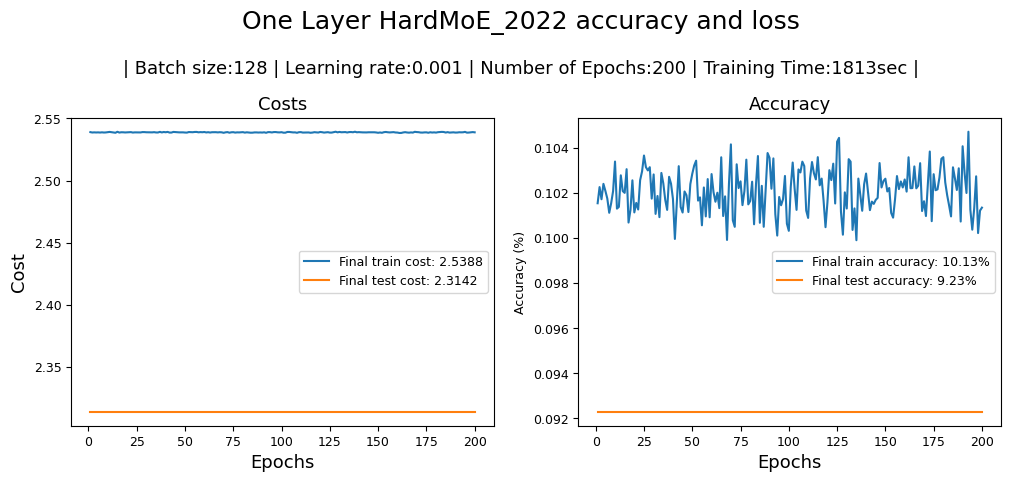

In [249]:
training_curve_plot(
    title="One Layer HardMoE_2022 accuracy and loss", 
    train_costs=training_loss, 
    test_costs=test_loss, 
    train_accuracy=training_accuracy, 
    test_accuracy=test_accuracy, 
    batch_size=BATCH_SIZE, 
    learning_rate=LEARNING_RATE, 
    training_time=training_duration, 
    epochs=EPOCHS)

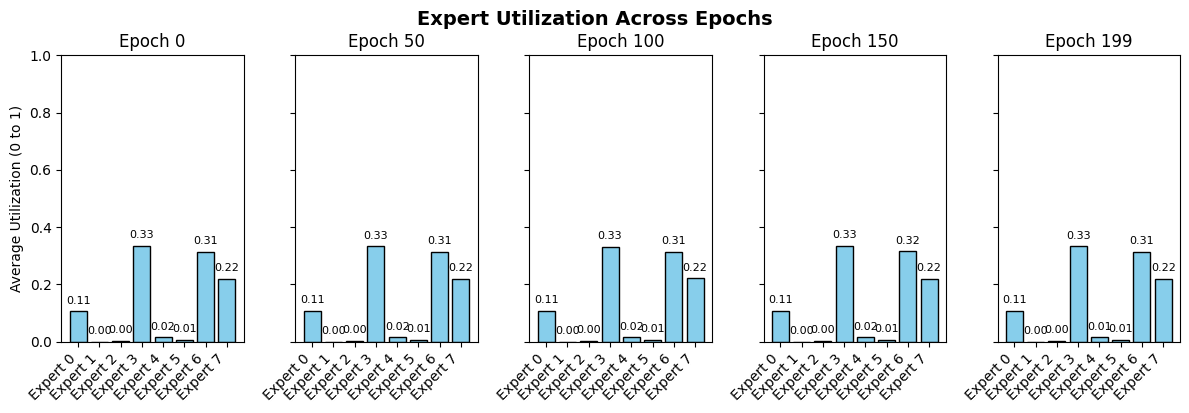

In [252]:
plot_utilization_histogram(
    epochs_to_plot=[0,50,100,150,199], 
    utilization_data=expert_utilization_history
)

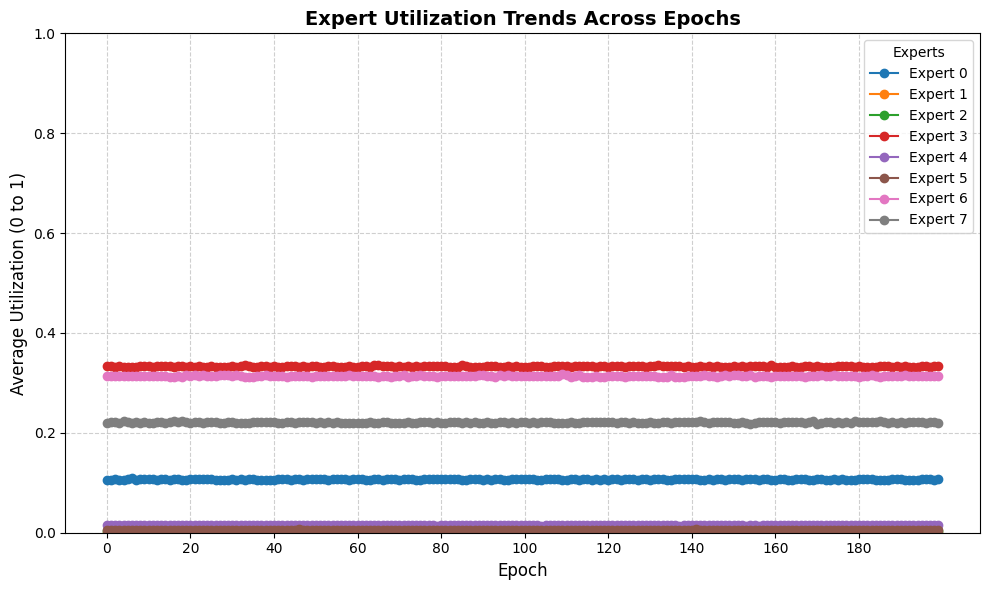

In [253]:
plot_utilization_trends(utilization_data=expert_utilization_history)

## 4 Evaluation  
### 4.1 Set up

In [18]:
moe.eval()

# Access model parameters and nodes
for name, param in moe.named_parameters():
    print(name, param.shape)
#This will not work because this is a HardMoE model so we cut out part of the model with gating topk
#print(get_graph_node_names(moe))

gate.l_1.weight torch.Size([10, 784])
gate.l_1.bias torch.Size([10])
gate.output.weight torch.Size([8, 10])
gate.output.bias torch.Size([8])
experts.0.l_1.weight torch.Size([25, 784])
experts.0.l_1.bias torch.Size([25])
experts.0.output.weight torch.Size([10, 25])
experts.0.output.bias torch.Size([10])
experts.1.l_1.weight torch.Size([25, 784])
experts.1.l_1.bias torch.Size([25])
experts.1.output.weight torch.Size([10, 25])
experts.1.output.bias torch.Size([10])
experts.2.l_1.weight torch.Size([25, 784])
experts.2.l_1.bias torch.Size([25])
experts.2.output.weight torch.Size([10, 25])
experts.2.output.bias torch.Size([10])
experts.3.l_1.weight torch.Size([25, 784])
experts.3.l_1.bias torch.Size([25])
experts.3.output.weight torch.Size([10, 25])
experts.3.output.bias torch.Size([10])
experts.4.l_1.weight torch.Size([25, 784])
experts.4.l_1.bias torch.Size([25])
experts.4.output.weight torch.Size([10, 25])
experts.4.output.bias torch.Size([10])
experts.5.l_1.weight torch.Size([25, 784])
e

In [19]:
# For getting the probability distribution for experts
#this again doesn't really work with HardMoE because of the topk
return_nodes = {
    "gate.softmax" : "probs"
}

# Getting the gating network
moe_gating = create_feature_extractor(moe, return_nodes=return_nodes)
moe_gating.eval()

TraceError: symbolically traced variables cannot be used as inputs to control flow